# Results from binary classification

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
plt.style.use("seaborn")
%matplotlib inline
import datetime as dt

We have multiple options for the choice of colors. [Claus O. Wilke](https://clauswilke.com/dataviz/color-pitfalls.html) defines a few colors that are suitable for a wide audience (including people with a color-vision deficiency). 

* orange #E69F00
* sky blue #56B4E9
* bluish green #009E73
* yellow #F0E442
* blue #0072B2
* vermilion #D55E00
* reddish purple #CC79A7
* black #000000

In [2]:
blue = '#0072B2'
bluegreen = '#009E73'
yellow = '#F0E442'
skyblue = '#56B4E9'
orange = '#E69F00'
vermilion = '#D55E00'

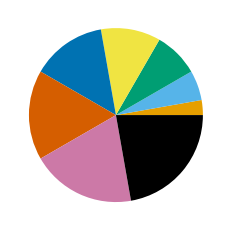

In [3]:
wedges = plt.pie(
    [1,2,3,4,5,6,7,8],
    colors = ["#E69F00",skyblue,"#009E73",yellow,"#0072B2","#D55E00","#CC79A7","#000000"]
)

## Importing shapefiles

First thing we do is to import the NUTS 3 level shapefiles from Eurostat, available at [Eurostat](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts#nuts21).

In [4]:
gdf_nuts3 = gpd.read_file(
    'data/NUTS_RG_01M_2021_3857_LEVL_3.shp.zip',
    crs = "EPSG:4326"
)

In [5]:
# Filter out all countries except Norway
gdf_NOnuts3 = gdf_nuts3[gdf_nuts3.CNTR_CODE.str.contains('NO')]
# We manually filter out Svalbard and Jan Mayen as we are not interested in them
gdf_NOnuts3 = gdf_NOnuts3.query('FID != "NO0B1" and FID != "NO0B2"')
# Return to sequential index from 0 to 13
gdf_NOnuts3 = gdf_NOnuts3.reset_index()
# Set the coordinate reference system to EPSG:4326 - same as our twitter data. 
gdf_NOnuts3 = gdf_NOnuts3.to_crs("EPSG:4326")

## Twitter data

We start by simply loading the data from our csv file

In [6]:
df_twitter = pd.read_csv(
    "data/fourth_rendition_geolocated_id_posneutral_predict.csv",
    parse_dates=[
        'created_at'
    ]
).drop(columns={'id'})

### Aggregated temporal analysis

In [7]:
df_twitter_monthly = pd.DataFrame(df_twitter.copy())

In [8]:
df_twitter_monthly.index = df_twitter_monthly[
    'created_at'
].dt.to_period(
    'M'
)

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='Year', ylabel='Number of tweets'>

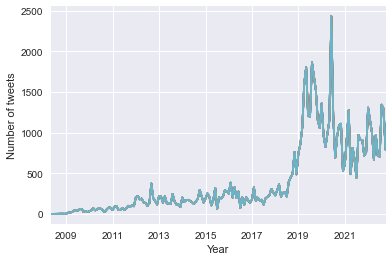

In [9]:
df_twitter_monthly.groupby(
    level=0
).count(
).plot(
    xlabel = 'Year',
    ylabel = 'Number of tweets',
    legend = None,
    #title = 'Number of tweets over time'
)

#plt.savefig('.pdf')

### With sentiment scores
We then caluclate the sentiment score and do analysis. In the binary classification, 0 = negative and 1 = non-negative

In [10]:
df_twitter_monthly_senti = pd.DataFrame(df_twitter.copy())

In [11]:
df_twitter_monthly_senti.index = df_twitter_monthly_senti['created_at'].dt.to_period('M')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [12]:
# We first calculate the total number of values for each months
total_sentiments = df_twitter_monthly_senti.groupby(level=0).count()
total_sentiments

,Unnamed: 0,username,text,loc,created_at,like_count,quote_count,latitude,longitude,label,logits0,logits1
created_at,,,,,,,,,,,,
2008-05,2,2,2,2,2,2,2,2,2,2,2,2
2008-06,2,2,2,2,2,2,2,2,2,2,2,2
2008-08,2,2,2,2,2,2,2,2,2,2,2,2
2008-09,3,3,3,3,3,3,3,3,3,3,3,3
2008-11,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06,718,718,718,718,718,718,718,718,718,718,718,718
2022-07,706,706,706,706,706,706,706,706,706,706,706,706
2022-08,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344


In [13]:
# then next, we calculate the sum of the label values, which will correspond to the total amount of non-negative tweets
average_sentiments = df_twitter_monthly_senti.groupby(level=0).sum()
average_sentiments

,Unnamed: 0,username,like_count,quote_count,latitude,longitude,label,logits0,logits1
created_at,,,,,,,,,
2008-05,29,1511241,0,0,122.924491,14.277079,2.0,-3.947274,3.468464
2008-06,25,764692,0,0,121.892035,19.962941,2.0,-3.690972,2.934177
2008-08,21,1144788,0,0,122.935074,19.717435,2.0,-3.362445,3.116579
2008-09,24,1406863,0,0,179.729408,26.776555,3.0,-2.118445,1.752894
2008-11,18,3212280,0,0,242.746668,25.436182,3.0,-2.782082,2.028387
...,...,...,...,...,...,...,...,...,...
2022-06,46190017,382498913,1937,29,43521.887091,6804.042502,614.0,-730.136930,733.846842
2022-07,45920711,389429185,2080,24,42689.877041,6750.055833,527.0,-438.782962,425.076650
2022-08,88796064,739271967,4328,66,81394.481189,13194.313915,990.0,-821.042164,827.339425


In [14]:
# 1 = positive, 0 = negative 
# the amount of negative sentiments is calculated by the total amount of sentiments minus the amount of non-negative
# the amount of non-negative is calculated before
df_twitter_monthly_senti['negative_sentiment'] = total_sentiments['label'] - average_sentiments['label']
df_twitter_monthly_senti['non-negative_sentiment'] = average_sentiments['label']

In [15]:
df_twitter_monthly_senti

,Unnamed: 0,username,text,loc,created_at,like_count,quote_count,latitude,longitude,label,logits0,logits1,negative_sentiment,non-negative_sentiment
created_at,,,,,,,,,,,,,,
2008-12,0,906614,445 millioner vindkraft to planlagte vindkraft...,Nordmøre,2008-12-16 14:43:57+00:00,0,0,63.021744,8.978465,1.0,-0.378610,0.694487,1.0,2.0
2008-12,1,703110,kvifor byggja på karl johan e jo oslo folk bur...,Lofoten,2008-12-08 14:12:10+00:00,0,0,68.333056,14.666389,0.0,0.142614,0.061452,1.0,2.0
2008-12,2,238174,nyhet vil heller vindkraft,Oslo,2008-12-08 07:25:53+00:00,0,0,59.913330,10.738970,1.0,-1.232807,0.704550,1.0,2.0
2008-11,3,755559,vindkraft mulighet vindmølleparker vekker str...,Bergen,2008-11-25 05:33:07+00:00,0,0,60.394306,5.325919,0.0,0.289026,-0.386826,1.0,3.0
2008-11,4,755559,vil spreie vindturbinar halve kommunen det pl...,Bergen,2008-11-18 09:33:01+00:00,0,0,60.394306,5.325919,1.0,-0.152227,0.363067,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10,68824,83460,foreslår de ønsker andre steder myndighetene l...,Oslo,2022-10-17 05:17:26+00:00,26,0,59.913330,10.738970,1.0,-1.879917,2.161498,176.0,617.0
2022-10,68825,786207,det norske selskapet wind catching systems as ...,Trondheim,2022-10-17 05:05:54+00:00,0,0,63.430566,10.395193,0.0,0.506162,-0.262411,176.0,617.0
2022-10,68826,790862,kjellbolme vindkraft engang nok å holde selv g...,Grimstad,2022-10-17 04:52:54+00:00,0,0,58.283997,8.712829,1.0,-1.624369,1.718985,176.0,617.0


In [16]:
df_twitter_monthly_senti = df_twitter_monthly_senti.rename(columns={'created_at':'year_month'}).sort_values('year_month')

In [17]:
df_twitter_monthly_senti

,Unnamed: 0,username,text,loc,year_month,like_count,quote_count,latitude,longitude,label,logits0,logits1,negative_sentiment,non-negative_sentiment
created_at,,,,,,,,,,,,,,
2008-05,15,906614,lund snur kappen vinden statoilhydro bruke 400...,Nordmøre,2008-05-22 11:36:20+00:00,0,0,63.021744,8.978465,1.0,-2.103070,2.054432,0.0,2.0
2008-05,14,604627,optimisme h sj midtfjellet vindkraft as f,Fitjar,2008-05-30 13:53:27+00:00,0,0,59.902747,5.298615,1.0,-1.844204,1.414032,0.0,2.0
2008-06,13,382346,norge i havvindsamarbeid teknisk ukeblad,Nordre Land,2008-06-26 14:08:16+00:00,0,0,60.946017,9.981471,1.0,-2.222354,2.225309,0.0,2.0
2008-06,12,382346,prest vindkraft,Nordre Land,2008-06-30 12:07:35+00:00,0,0,60.946017,9.981471,1.0,-1.468619,0.708868,0.0,2.0
2008-08,11,906614,oljeministeren ser solkraft norges nye olje en...,Nordmøre,2008-08-05 08:56:27+00:00,0,0,63.021744,8.978465,1.0,-2.146194,2.337655,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10,68622,944240,under oljekrisa 70tallet det stor diskusjon da...,Oslo,2022-10-22 10:03:34+00:00,1,0,59.913330,10.738970,1.0,-1.236344,1.553373,176.0,617.0
2022-10,68621,944240,utgjorde viktig del det danske industrieventyr...,Oslo,2022-10-22 10:03:34+00:00,2,0,59.913330,10.738970,1.0,-1.208077,1.560004,176.0,617.0
2022-10,68620,130954,eisalen å skjønner du få til se lite men tenk ...,Oslo,2022-10-22 12:12:15+00:00,5,0,59.913330,10.738970,1.0,-1.012027,1.408046,176.0,617.0


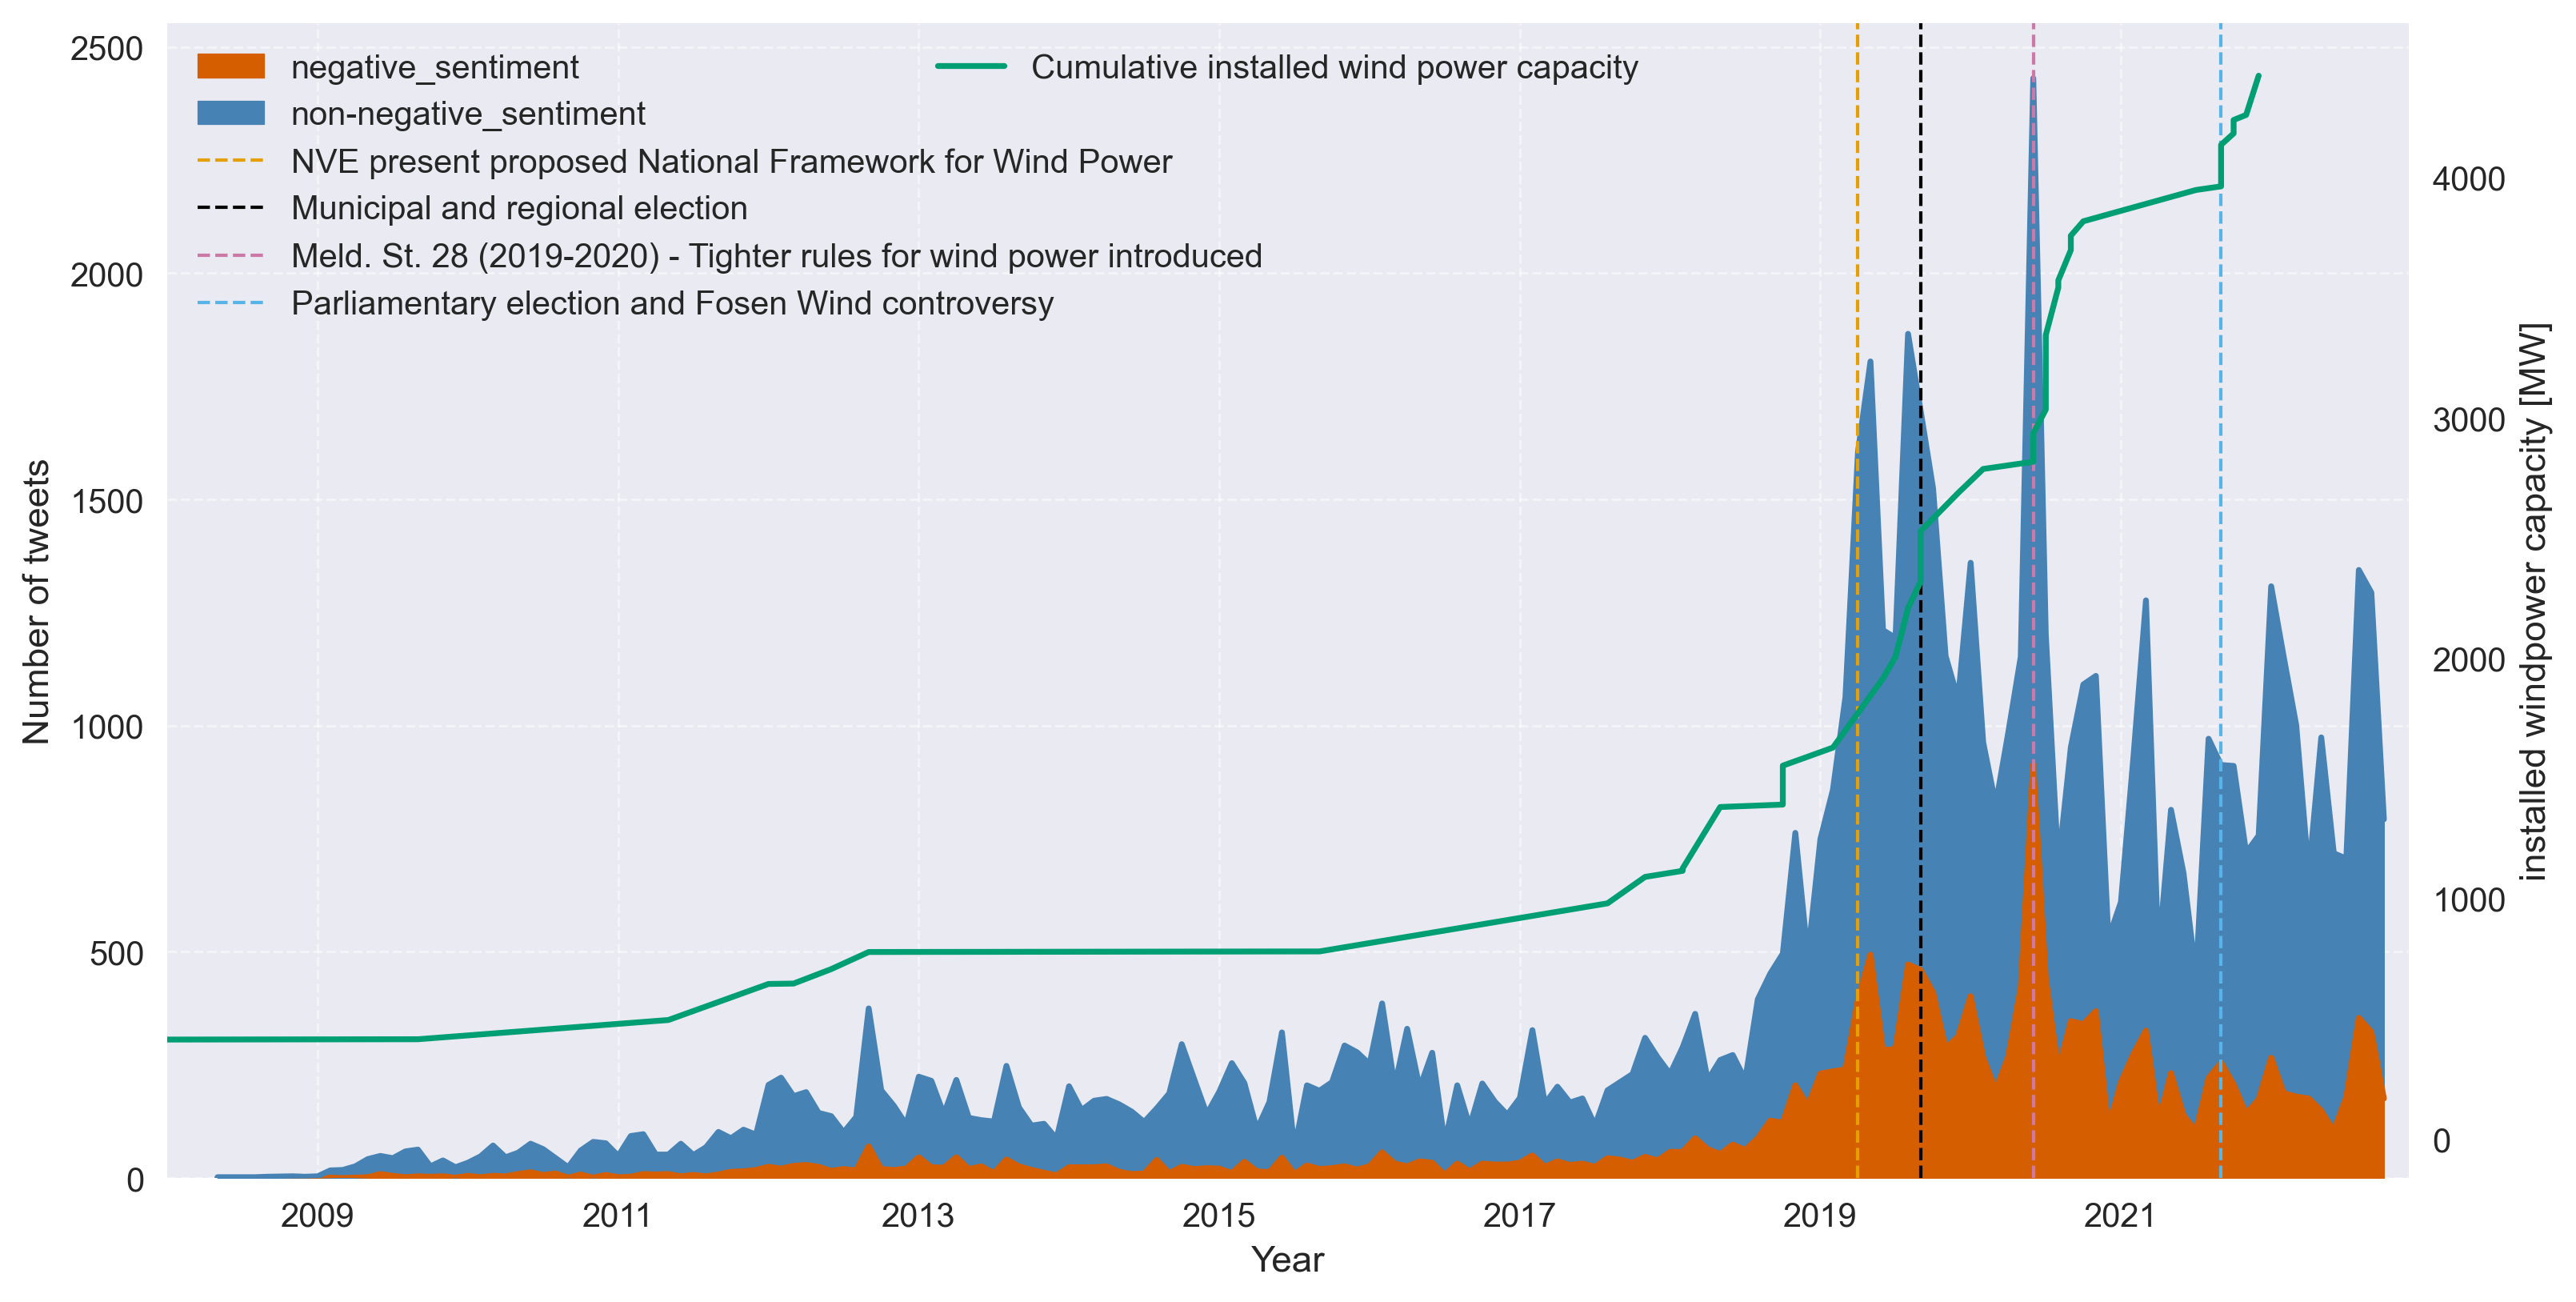

In [19]:
xs = [0,100]
fig, ax = plt.subplots(figsize=(3*3.54,1.5*3.54), dpi=300,layout="constrained")

ax2 = ax.twinx()
df_twitter_monthly_senti.plot.area(
    ax=ax,
    y = ['negative_sentiment','non-negative_sentiment'],
    #title = 'Amount of tweets over time (aggregated monthly), with binary classification',
    color = [vermilion,'steelblue']
)

ax.axvline(
    dt.datetime(2019, 4, 1),
    color="#E69F00",
    label='NVE present proposed National Framework for Wind Power',
    linestyle = "--",
    linewidth=1
)

ax.axvline(
    dt.datetime(2019, 9, 1),
    color="#000000",
    label='Municipal and regional election',
    linestyle = "--",
    linewidth=1
)

ax.axvline(
    dt.datetime(2020, 6, 1),
    color="#CC79A7",
    label='Meld. St. 28 (2019-2020) - Tighter rules for wind power introduced',
    linestyle = "--",
    linewidth=1
)

ax.axvline(
    dt.datetime(2021, 9, 1),
    color="#56B4E9",
    label='Parliamentary election and Fosen Wind controversy',
    linestyle = "--",
    linewidth=1
)

ax.legend(loc='upper left',frameon=False)
ax.grid(linestyle = '--', alpha = 0.5, linewidth = 0.75)
ax.set_xlabel('Year')
ax.set_ylabel('Number of tweets')

df_wp = pd.read_csv(
    'data/vindkraft_utbygd.csv', 
    sep = ";"
).assign(
    in_operation = lambda x : pd.to_datetime(x.forsteIdriftDato,unit='ms')
).groupby(
    'in_operation',
    as_index = True
).sum(
).rename(
    columns=
    {
        'forventetProduksjon_Gwh': 'expected_generation_GWh',
        'effekt_MW': 'installed_capacity_MW'
    }
).assign(
    cumulative_annually_average_production_GWh = lambda x: x.expected_generation_GWh.cumsum(),
    cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
)

df_wp.plot(
        ax=ax2,
        y = ['cumulative_installed_capacity_MW'], #, 'average_generation_GWh'],
        color = bluegreen
)

ax.set_xlim([dt.date(2008, 1, 1), dt.date(2022, 12, 12)])
ax2.grid(False)
ax2.legend(['Cumulative installed wind power capacity'], loc = 'upper center',frameon=False)
ax2.set_ylabel('installed windpower capacity [MW]')

#plt.savefig('figures/tweets_over_time_monthly_agg.png',bbox_inches='tight', facecolor='white', edgecolor='black')
plt.savefig('figures/tweets_over_time_monthly_agg_area.pdf',bbox_inches='tight')
#plt.savefig('figures/tweets_over_time_monthly_agg_area.eps',bbox_inches='tight')

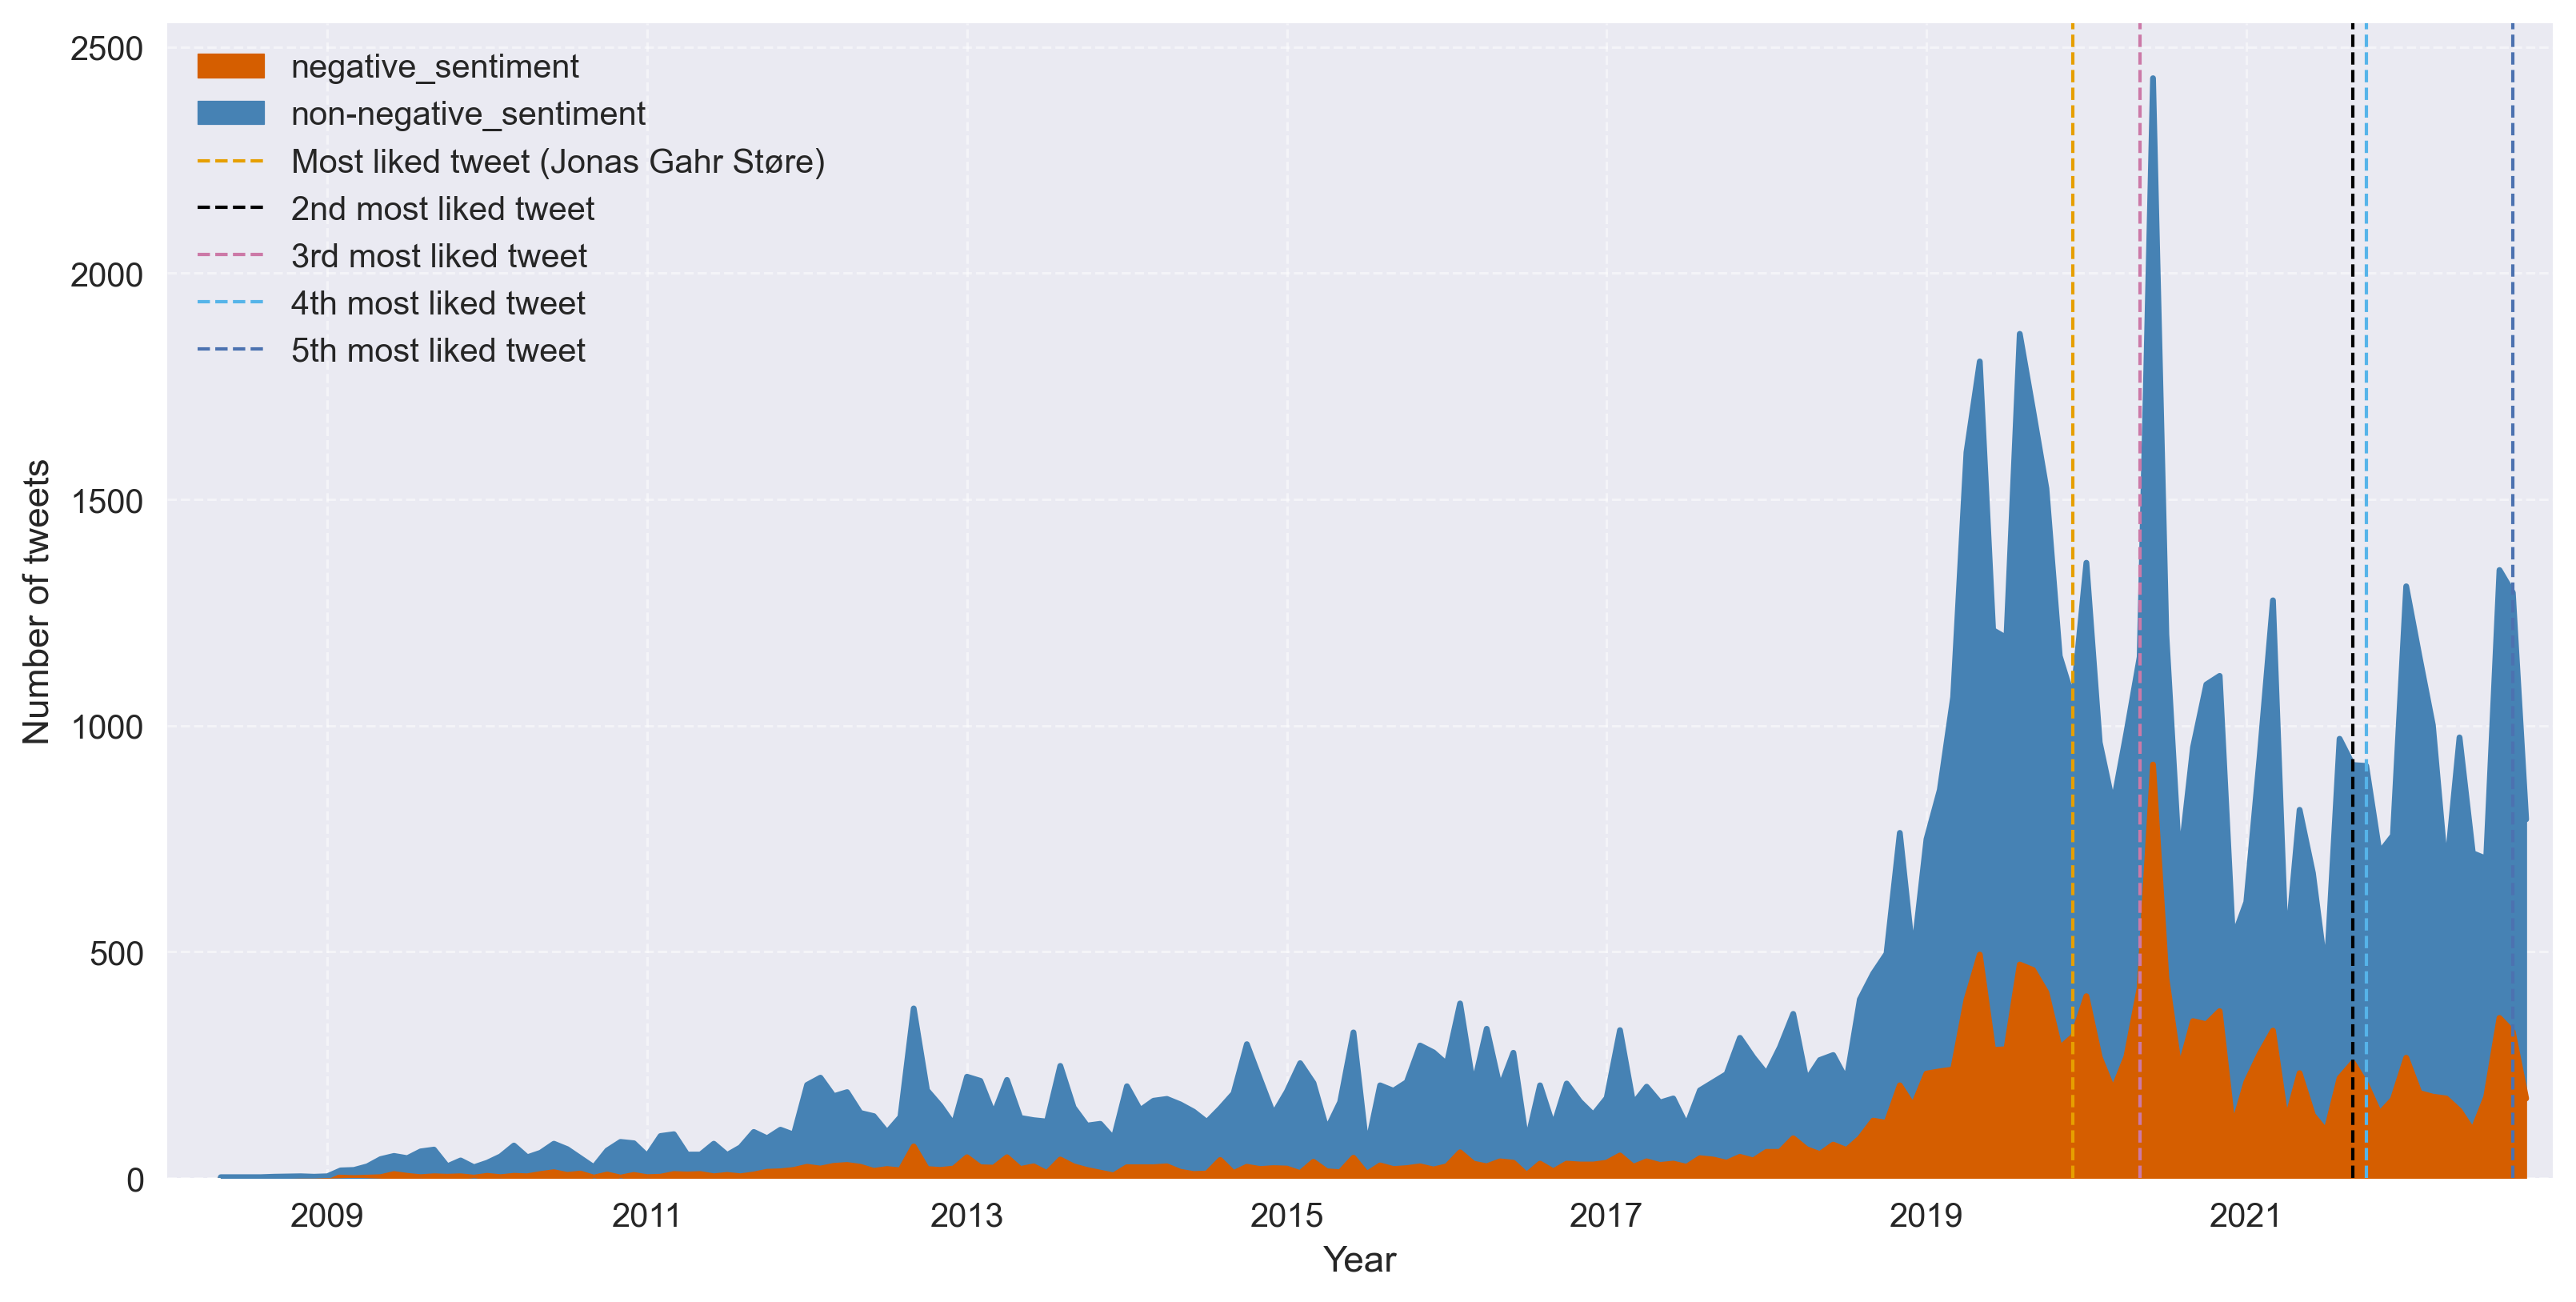

In [23]:
xs = [0,100]
fig, ax = plt.subplots(figsize=(3*3.54,1.5*3.54), dpi=300,layout="constrained")

df_twitter_monthly_senti.plot.area(
    ax=ax,
    y = ['negative_sentiment','non-negative_sentiment'],
    #title = 'Amount of tweets over time (aggregated monthly), with binary classification',
    color = [vermilion,'steelblue']
)

ax.axvline(
    dt.datetime(2019, 12, 18),
    color="#E69F00",
    label='Most liked tweet (Jonas Gahr Støre)',
    linestyle = "--",
    linewidth=1
)

ax.axvline(
    dt.datetime(2021, 9, 6),
    color="#000000",
    label='2nd most liked tweet',
    linestyle = "--",
    linewidth=1
)

ax.axvline(
    dt.datetime(2020, 5, 27),
    color="#CC79A7",
    label='3rd most liked tweet',
    linestyle = "--",
    linewidth=1
)

ax.axvline(
    dt.datetime(2021, 10, 6),
    color="#56B4E9",
    label='4th most liked tweet',
    linestyle = "--",
    linewidth=1
)

ax.axvline(
    dt.datetime(2022, 9, 21),
    label='5th most liked tweet',
    linestyle = "--",
    linewidth=1
)

ax.legend(loc='upper left',frameon=False)
ax.grid(linestyle = '--', alpha = 0.5, linewidth = 0.75)
ax.set_xlabel('Year')
ax.set_ylabel('Number of tweets')
ax.set_xlim([dt.date(2008, 1, 1), dt.date(2022, 12, 12)])
plt.savefig('figures/most_liked_tweets_time.png',bbox_inches="tight")

### Spatial analysis

In [19]:
# Transform the twitter data it into a GeoDataFrame with point geometry based on longitude and latitude.
gdf_twitter = gpd.GeoDataFrame(
    df_twitter,
    crs = "EPSG:4326",
    geometry=gpd.points_from_xy(
        df_twitter.longitude, 
        df_twitter.latitude
    )
)

In [20]:
gdf_twitter = gdf_twitter.rename(
    columns={
        "loc": "city"
    }
)

In [21]:
# Create a new list with one row for each city
gdf_twitter_grouped = gdf_twitter[gdf_twitter.city != "Longyearbyen"]
gdf_twitter_grouped = gdf_twitter.groupby(
    'city'
).first(
)

In [22]:
# Add a new column 'twitter_frequency' with the number of times each city occur.
# This amounts to the twitter frequency.
gdf_twitter_grouped[
    'twitter_frequency'
] = gdf_twitter[
    'city'
].value_counts(
)

In [23]:
# Only select the relevant columns
gdf_twitter_grouped_sorted = gdf_twitter_grouped[
    [
        "geometry",
        "twitter_frequency",
        "label"
    ]
]
gdf_twitter_grouped_sorted = gdf_twitter_grouped_sorted.reset_index()

In [24]:
gdf_twitter_grouped_sorted

,city,geometry,twitter_frequency,label
0,Adamstuen,POINT (10.73322 59.93345),7,1.0
1,Agdenes,POINT (9.51508 63.58289),4,0.0
2,Agder,POINT (8.03496 58.71944),9,1.0
3,Aker brygge,POINT (10.72504 59.90993),5,1.0
4,Akershus,POINT (11.32017 60.03852),75,1.0
...,...,...,...,...
708,Øvre Årdal,POINT (7.80398 61.31004),12,1.0
709,Øyenkilen,POINT (10.85062 59.17166),1,1.0
710,Øyer,POINT (10.50400 61.32735),3,1.0
711,Øygarden,POINT (7.85664 58.07864),23,0.0


In [25]:
# Spatial joins https://geopandas.org/docs/user_guide/mergingdata.html#spatial-joins
# Basically, we add an attribute for each city related to the county the coordinate is located inside.
gdf_twitter_with_county = gdf_twitter_grouped_sorted.sjoin(
    gdf_NOnuts3, 
    how = "inner", 
    predicate = 'intersects')

# Summate the different cities within each county
gdf_frequency_county = gdf_twitter_with_county.groupby(
    'NUTS_NAME'
).sum()
gdf_frequency_county.head(5)

,twitter_frequency,label,index_right,index,LEVL_CODE,MOUNT_TYPE,URBN_TYPE,COAST_TYPE
NUTS_NAME,,,,,,,,
Agder,770,22.0,232,23577,87,58.0,58.0,29
Innlandet,2591,58.0,370,55130,222,222.0,222.0,222
Møre og Romsdal,873,33.0,396,66044,132,132.0,132.0,44
Nordland,915,33.0,470,70594,141,141.0,141.0,47
Oslo,32901,34.0,240,31680,120,120.0,40.0,40


In [26]:
# https://www.ssb.no/statbank/table/07459/tableViewLayout1/
gdf_frequency_county['population'] = [311134,
                                      371253,
                                      265848,
                                      240190,
                                      699827,
                                      485797,
                                      241736,
                                      474131,
                                      424832,
                                      641292,
                                      1269230]
gdf_frequency_county = gdf_frequency_county.assign(
    tweets_per_cap = lambda x: x.twitter_frequency/x.population
)
gdf_frequency_county

,twitter_frequency,label,index_right,index,LEVL_CODE,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,population,tweets_per_cap
NUTS_NAME,,,,,,,,,,
Agder,770,22.0,232,23577,87,58.0,58.0,29,311134,0.002475
Innlandet,2591,58.0,370,55130,222,222.0,222.0,222,371253,0.006979
Møre og Romsdal,873,33.0,396,66044,132,132.0,132.0,44,265848,0.003284
Nordland,915,33.0,470,70594,141,141.0,141.0,47,240190,0.003809
Oslo,32901,34.0,240,31680,120,120.0,40.0,40,699827,0.047013
Rogaland,4280,33.0,41,29438,123,82.0,82.0,41,485797,0.008810
Troms og Finnmark,1122,35.0,184,33166,138,138.0,138.0,46,241736,0.004641
Trøndelag,6718,59.0,216,51840,216,144.0,144.0,72,474131,0.014169
Vestfold og Telemark,1257,39.0,301,34228,129,86.0,86.0,43,424832,0.002959


In [27]:
gdf_frequency_county.twitter_frequency.Oslo/gdf_frequency_county.twitter_frequency.sum()

0.5156492437896717

In [28]:
gdf_frequency_county.population.Oslo/gdf_frequency_county.population.sum()

0.12899394868826805

Oslo has almost 54% of the tweets, although only representing 13% of the population

Text(0, 0.5, 'Number of tweets')

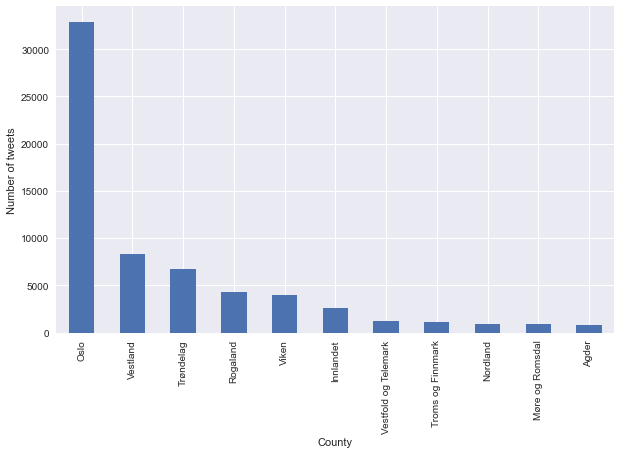

In [29]:
gdf_frequency_county.twitter_frequency.sort_values(
    ascending=False
)

#ax = gdf_frequency_county.tweets_per_cap.plot(
#    secondary_y=True
#)

gdf_frequency_county.twitter_frequency.sort_values(
    ascending=False
).plot.bar(
    legend = None,
    figsize = (10,6),
#    ax=ax
)

#plt.tick_params(axis='y', labelleft='off', labelright='on')
plt.xlabel('County')
plt.ylabel('Number of tweets')
#plt.savefig('figures/tweet_frequency.png',bbox_inches='tight')



## Heat maps

In [30]:
test = gdf_twitter.copy()
test = test.drop(columns={'like_count','quote_count','username','text','Unnamed: 0'})

In [31]:
test = test.sjoin(
    gdf_NOnuts3, 
    how="inner", 
    predicate='intersects'
).drop(
    columns={
        'MOUNT_TYPE',
        'URBN_TYPE',
        'COAST_TYPE',
        'FID',
        'LEVL_CODE',
        'CNTR_CODE',
        'NAME_LATN'
    }
)

In [32]:
gdf_twitter_yearly_senti = gpd.GeoDataFrame(test.copy())

In [33]:
gdf_twitter_yearly_senti

,city,created_at,latitude,longitude,label,logits0,logits1,geometry,index_right,index,NUTS_ID,NUTS_NAME
0,Nordmøre,2008-12-16 14:43:57+00:00,63.021744,8.978465,1.0,-0.378610,0.694487,POINT (8.97846 63.02174),9,1501,NO0A3,Møre og Romsdal
5,Nordmøre,2008-11-05 14:23:09+00:00,63.021744,8.978465,1.0,-1.360976,0.927306,POINT (8.97846 63.02174),9,1501,NO0A3,Møre og Romsdal
11,Nordmøre,2008-08-05 08:56:27+00:00,63.021744,8.978465,1.0,-2.146194,2.337655,POINT (8.97846 63.02174),9,1501,NO0A3,Møre og Romsdal
15,Nordmøre,2008-05-22 11:36:20+00:00,63.021744,8.978465,1.0,-2.103070,2.054432,POINT (8.97846 63.02174),9,1501,NO0A3,Møre og Romsdal
174,Sunndal,2009-09-06 15:39:43+00:00,62.647029,8.652670,1.0,-1.600200,1.419614,POINT (8.65267 62.64703),9,1501,NO0A3,Møre og Romsdal
...,...,...,...,...,...,...,...,...,...,...,...,...
68717,Drammen,2022-10-18 10:20:19+00:00,59.696494,10.175642,0.0,0.309461,-0.575117,POINT (10.17564 59.69649),0,544,NO082,Viken
68720,Drammen,2022-10-18 09:50:34+00:00,59.696494,10.175642,1.0,-2.117668,2.165796,POINT (10.17564 59.69649),0,544,NO082,Viken
68744,Lillestrøm,2022-10-17 22:18:29+00:00,59.953415,11.045153,1.0,-0.286069,0.318295,POINT (11.04515 59.95341),0,544,NO082,Viken
68752,Drammen,2022-10-17 19:28:49+00:00,59.696494,10.175642,1.0,-0.991177,1.360778,POINT (10.17564 59.69649),0,544,NO082,Viken


In [34]:
gdf_twitter_yearly_senti['year'] = test['created_at'].dt.to_period('Y')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:>

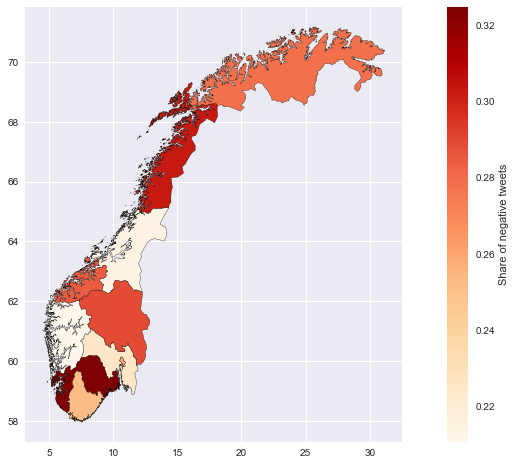

In [35]:
gdf_twitter_yearly_grouped = gdf_twitter_yearly_senti.loc[
    gdf_twitter_yearly_senti['year'] == "2019"
].groupby("NUTS_NAME").first(
).assign(
    non_negative_tweets = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == "2019"].groupby("NUTS_NAME").sum().label,
    amount = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == "2019"].groupby("NUTS_NAME").count().label,
    negative_tweets = lambda x: x.amount - x.non_negative_tweets,
    share_negative = lambda x: x.negative_tweets/x.amount
)

gdf_NOnuts3.merge(
    gdf_twitter_yearly_grouped["share_negative"],
    left_on = 'NUTS_NAME',
    right_on = 'NUTS_NAME'
).plot(
    "share_negative",
    legend = True,
    edgecolor = 'black',
    figsize = (16,8),
    cmap ='OrRd',
    legend_kwds={'label': "Share of negative tweets"}
)

In [36]:
gdf_NOnuts3.merge(
        gdf_twitter_yearly_grouped["share_negative"],
        left_on = 'NUTS_NAME',
        right_on = 'NUTS_NAME'
    ).drop(
    columns = {
        "index",
        "NUTS_ID",
        "LEVL_CODE",
        "CNTR_CODE",
        "NAME_LATN",
        "MOUNT_TYPE",
        "URBN_TYPE",
        "COAST_TYPE",
        "FID",
        "NUTS_NAME"
    }
)

,geometry,share_negative
0,"MULTIPOLYGON (((11.83973 59.84077, 11.85370 59...",0.225410
1,"MULTIPOLYGON (((7.09629 59.78278, 7.11059 59.7...",0.324737
2,"MULTIPOLYGON (((5.49146 62.01479, 5.50093 62.0...",0.210690
3,"MULTIPOLYGON (((14.32598 65.11892, 14.27506 65...",0.213828
4,"MULTIPOLYGON (((31.16727 70.38563, 31.16523 70...",0.278107
5,"POLYGON ((8.25170 61.07394, 8.22705 61.08383, ...",0.288984
6,"MULTIPOLYGON (((10.76479 59.82954, 10.77027 59...",0.260585
7,"MULTIPOLYGON (((10.59606 59.17623, 10.59499 59...",0.324528
8,"MULTIPOLYGON (((7.21467 59.67269, 7.23487 59.6...",0.252336
9,"MULTIPOLYGON (((9.06206 62.37261, 9.01855 62.3...",0.284483


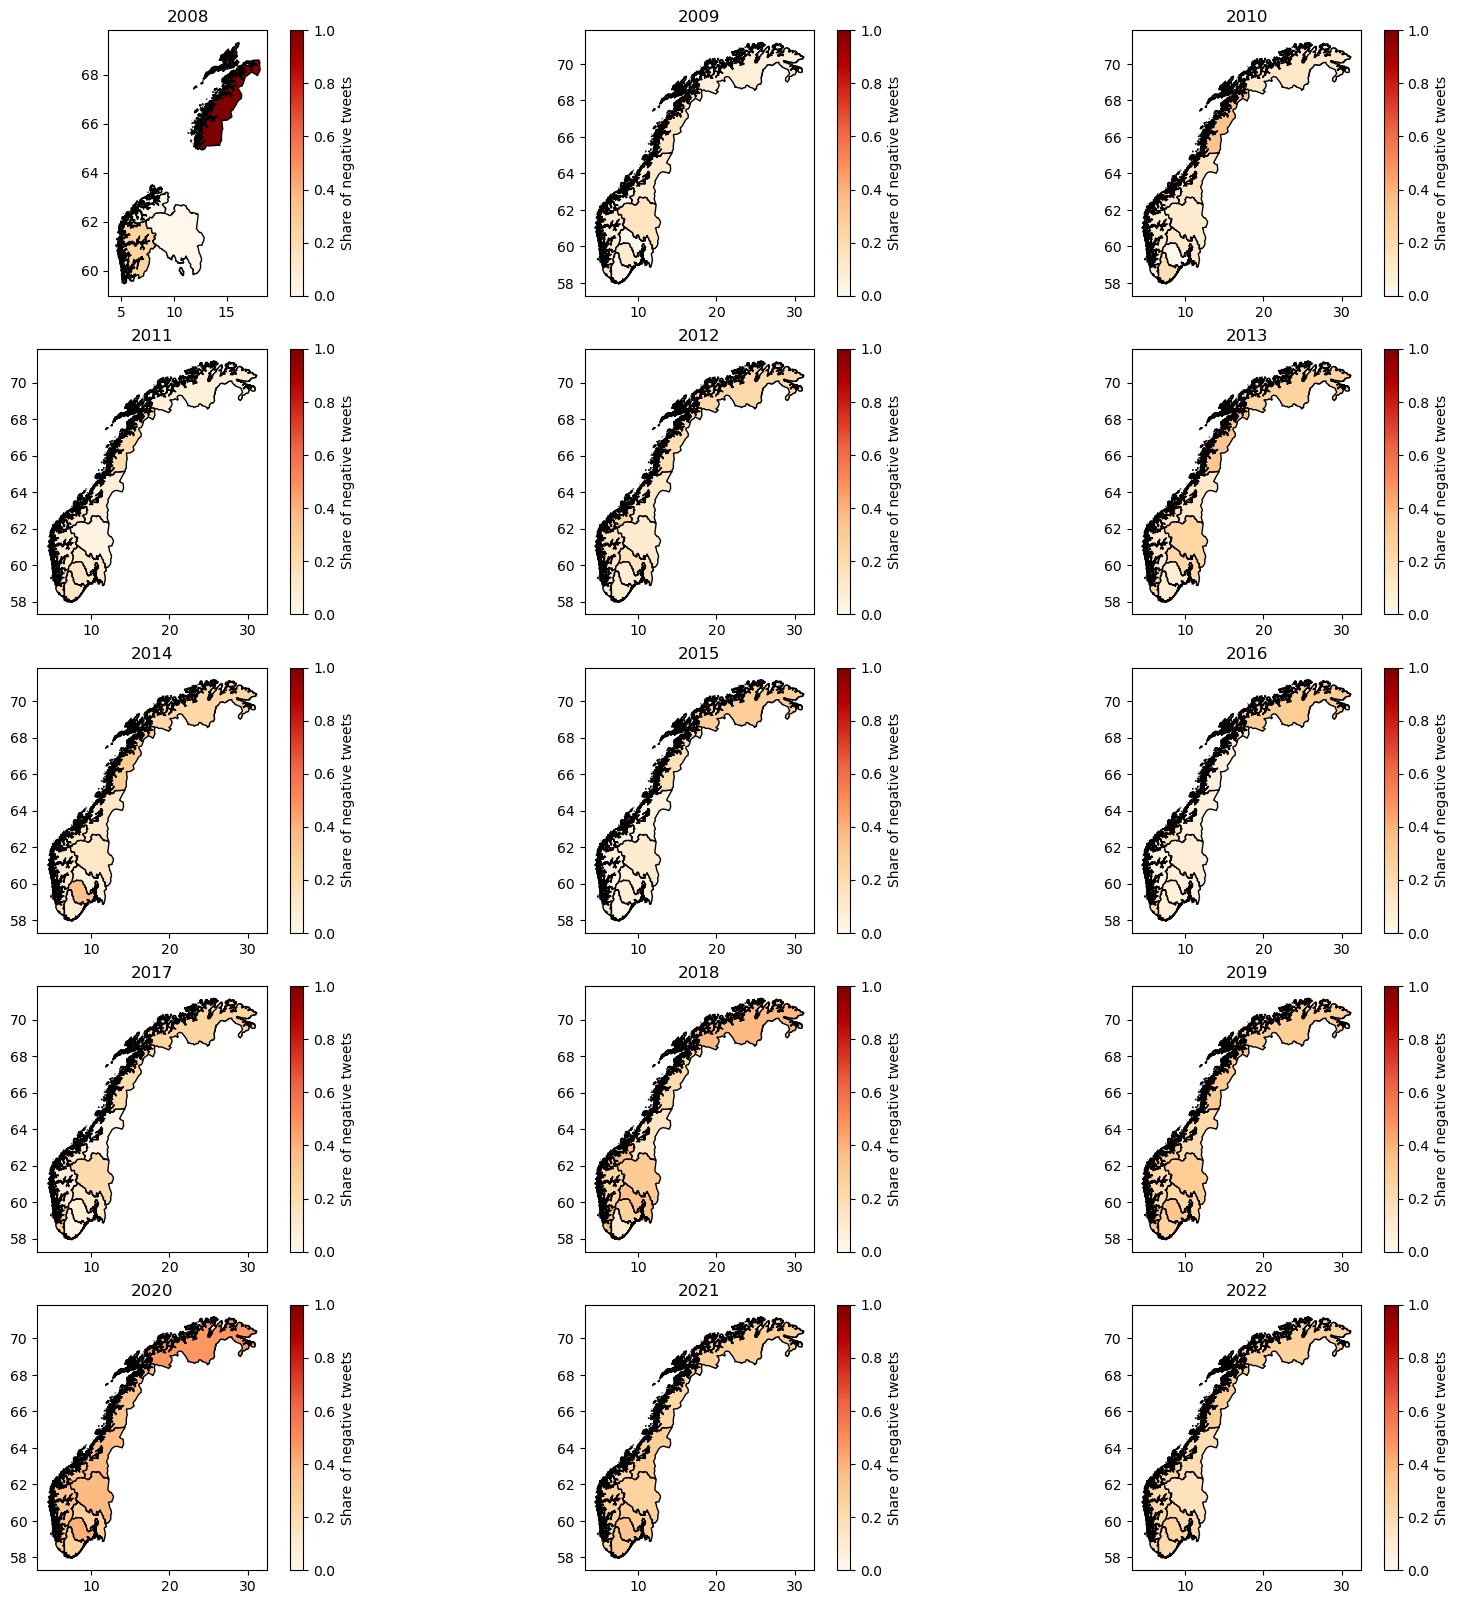

In [77]:
#years = ['2018','2019','2020','2021']
#for year in years:

fig = plt.figure(
    constrained_layout=False,
    figsize=(20,20)
)
gs = fig.add_gridspec(5,3)

row_nr = 0
column_nr = 0
for year in gdf_twitter_yearly_senti.groupby('year').sum().index:
    gdf_twitter_yearly_grouped = gdf_twitter_yearly_senti.loc[
        gdf_twitter_yearly_senti['year'] == year
    ].groupby("NUTS_NAME").first(
    ).assign(
        non_negative_tweets = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").sum().label,
        amount = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").count().label,
        negative_tweets = lambda x: x.amount - x.non_negative_tweets,
        share_negative = lambda x: x.negative_tweets/x.amount
    )

    gdf_NOnuts3.merge(
        gdf_twitter_yearly_grouped["share_negative"],
        left_on = 'NUTS_NAME',
        right_on = 'NUTS_NAME'
    ).plot(
        ax=fig.add_subplot(gs[row_nr,column_nr]),
        column = "share_negative",
        edgecolor = 'black',
        cmap ='OrRd',
        legend = True,
        legend_kwds={'label': "Share of negative tweets",
        'orientation': "vertical"},  
        vmin = 0,
        vmax = 1,
        figsize = (16,10)
    )
    
    plt.title(year)
    #plt.savefig('figures/heat_map_'+str(year)+'.eps')
    #plt.close()
    column_nr += 1
    if column_nr == 3:
        column_nr = 0
        row_nr += 1



In [38]:
for year in gdf_twitter_yearly_senti.groupby('year').sum().index:
    gdf_twitter_yearly_grouped = gdf_twitter_yearly_senti.loc[
        gdf_twitter_yearly_senti['year'] == year
    ].groupby("NUTS_NAME").first(
    ).assign(
        non_negative_tweets = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").sum().label,
        amount = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").count().label,
        negative_tweets = lambda x: x.amount - x.non_negative_tweets,
        share_negative = lambda x: x.negative_tweets/x.amount
    )

    gdf_NOnuts3.merge(
        gdf_twitter_yearly_grouped["share_negative"],
        left_on = 'NUTS_NAME',
        right_on = 'NUTS_NAME'
    ).plot(
        column = "share_negative",
        edgecolor = 'black',
        cmap ='OrRd',
        legend = True,
        legend_kwds={'label': "Share of negative tweets",
        'orientation': "vertical"},
        vmin = 0,
        vmax = 0.7,
        figsize = (16,10)
    )
    
    plt.title(year)
    #plt.savefig('gif/heat_map_'+str(year)+'.jpg')
    plt.close()

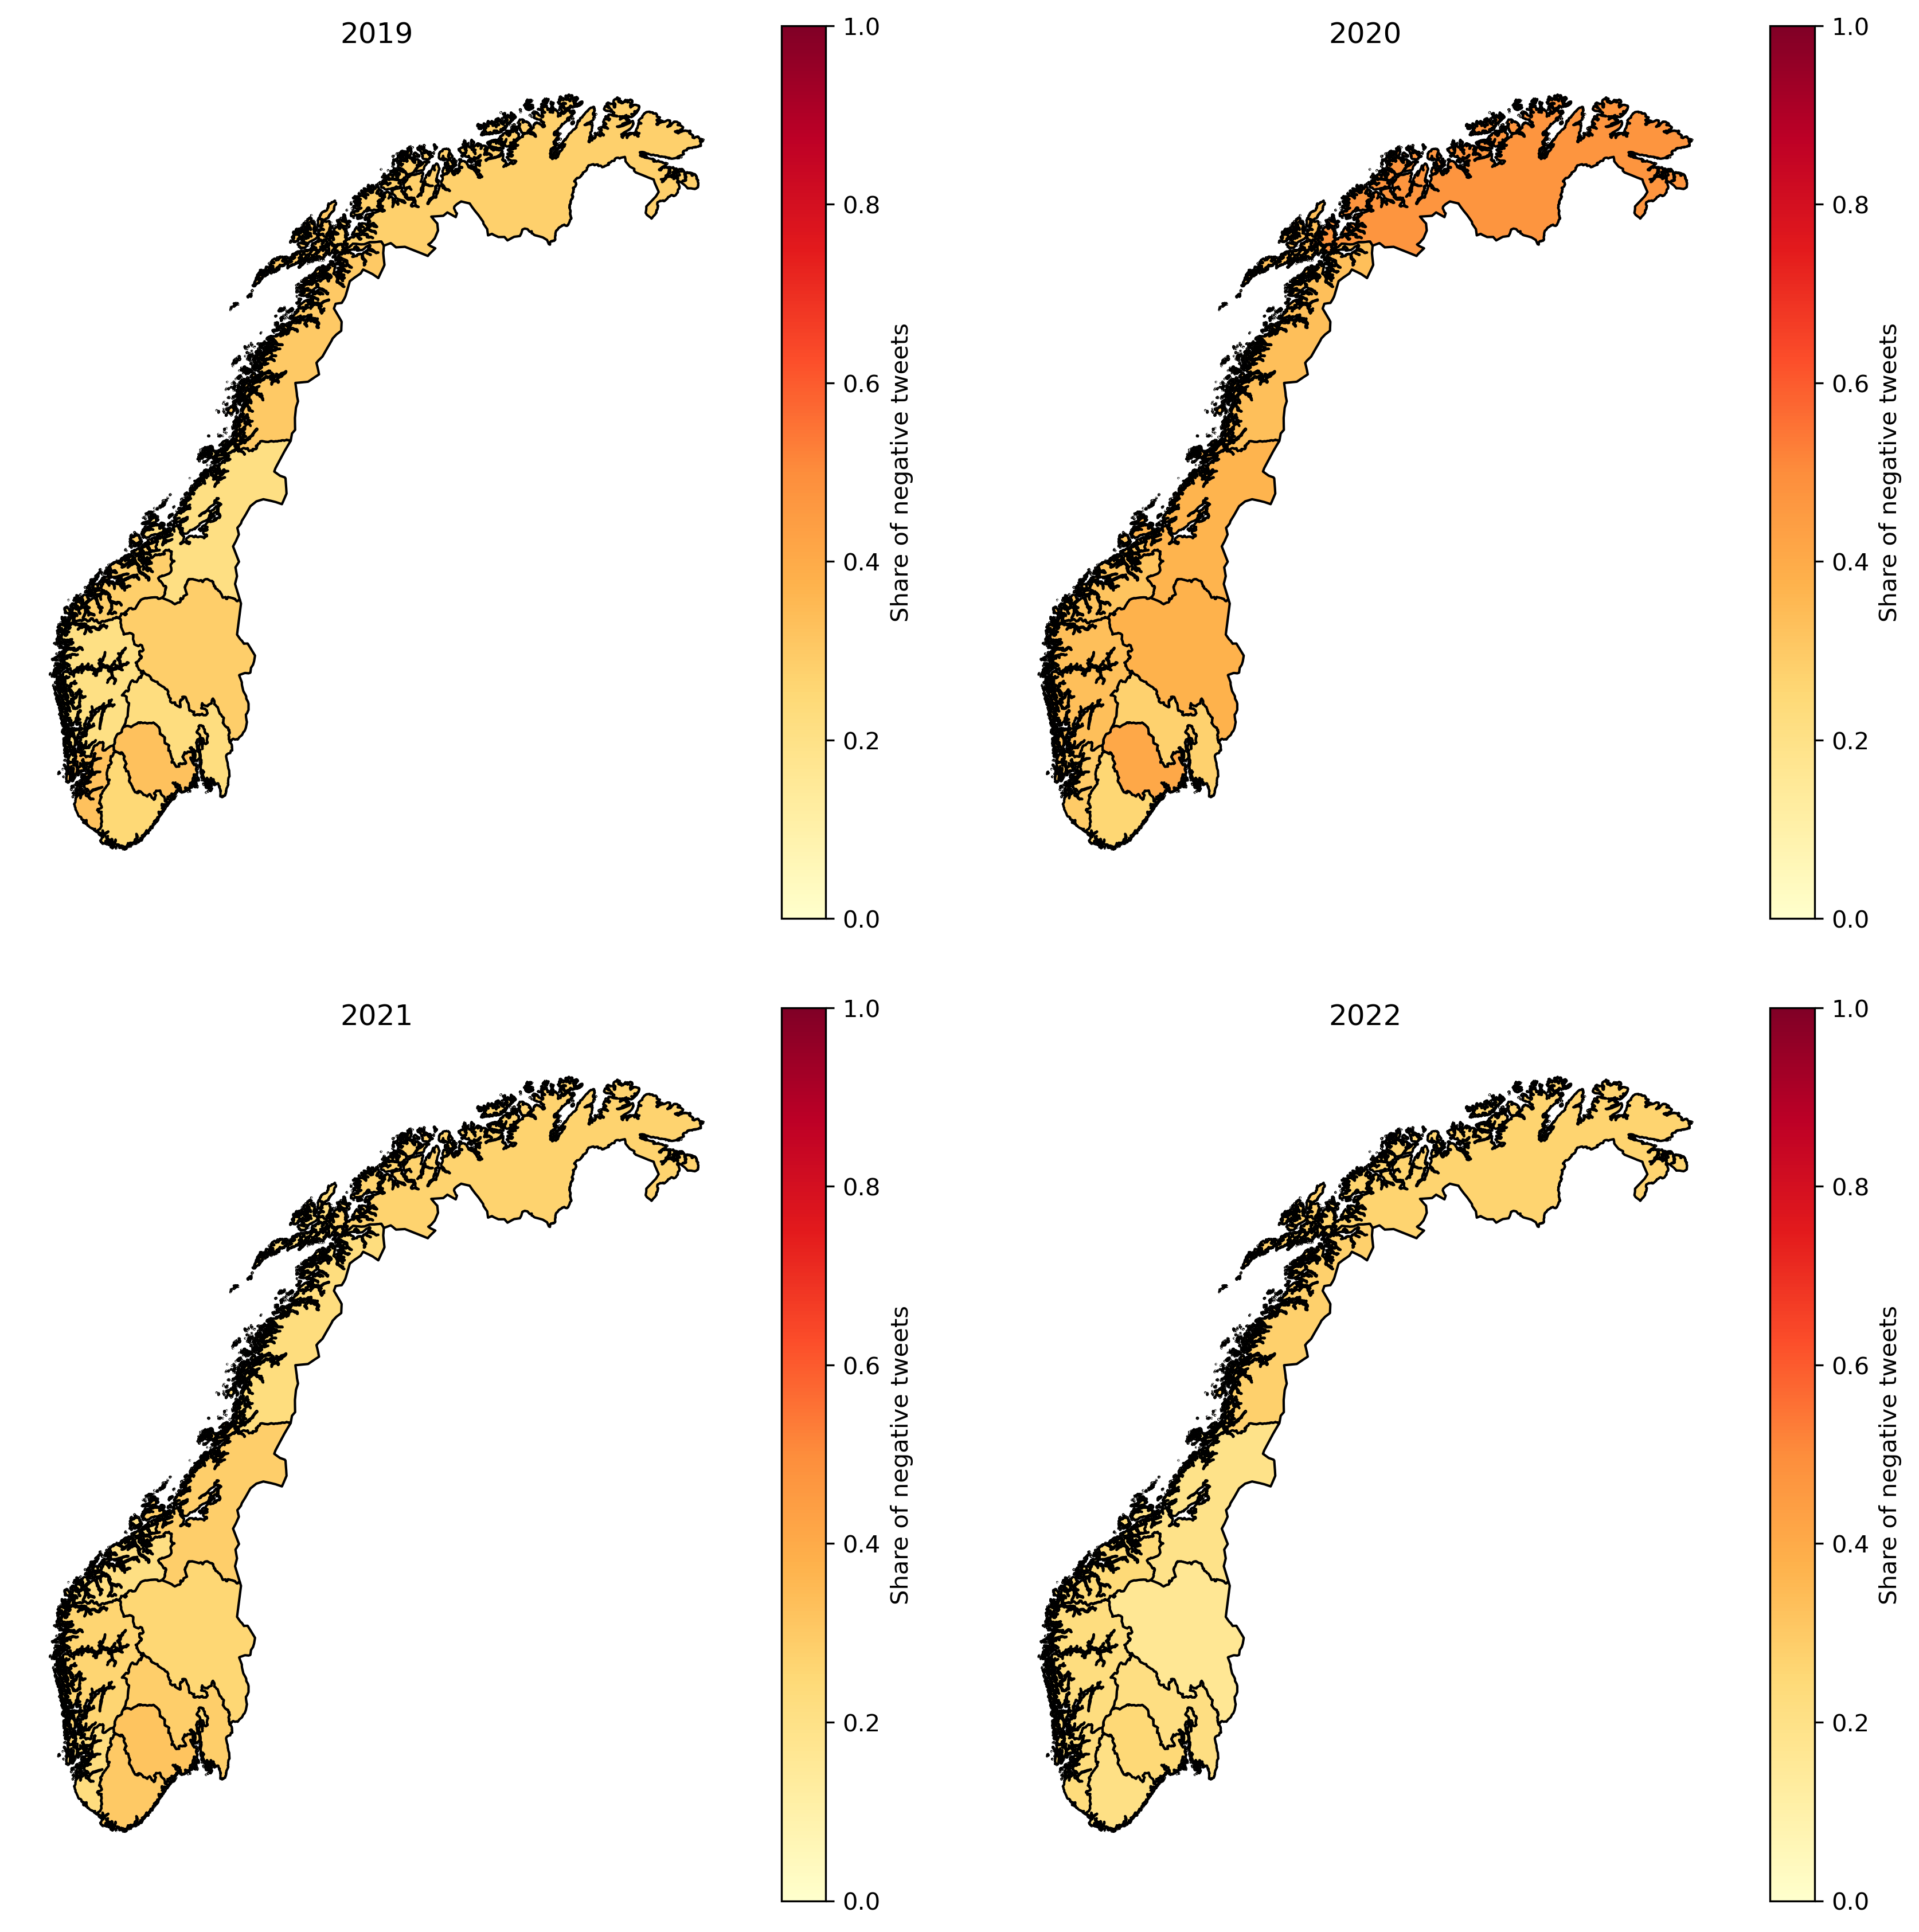

In [39]:
plt.style.use("default")

years = ['2019','2020','2021','2022']
row_nr = 0
column_nr = 0
fig = plt.figure(
    constrained_layout=False,
    figsize=(4*3.54,4*3.54),
    dpi = 300
)
gs = fig.add_gridspec(2,2,wspace = 0.1, hspace = 0.1)

for year in years:
    gdf_twitter_yearly_grouped = gdf_twitter_yearly_senti.loc[
        gdf_twitter_yearly_senti['year'] == year
    ].groupby("NUTS_NAME").first(
    ).assign(
        non_negative_tweets = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").sum().label,
        amount = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").count().label,
        negative_tweets = lambda x: x.amount - x.non_negative_tweets,
        share_negative = lambda x: x.negative_tweets/x.amount
    )

    gdf_NOnuts3.merge(
        gdf_twitter_yearly_grouped["share_negative"],
        left_on = 'NUTS_NAME',
        right_on = 'NUTS_NAME'
    ).plot(
        ax = fig.add_subplot(gs[row_nr,column_nr]),
        column = "share_negative",
        edgecolor = 'black',
        cmap ='YlOrRd',
        legend = True,
        legend_kwds={'label': "Share of negative tweets",
        'orientation': "vertical"},
        vmin = 0,
        vmax = 1,
    )
    
    column_nr += 1
    if column_nr == 2:
        column_nr = 0
        row_nr += 1
    
    plt.grid(False)
    plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
    plt.axis('off')
    plt.title(year)
plt.savefig('figures/heatMap_19_22.pdf', bbox_inches = 'tight',edgecolor=None)


<AxesSubplot:>

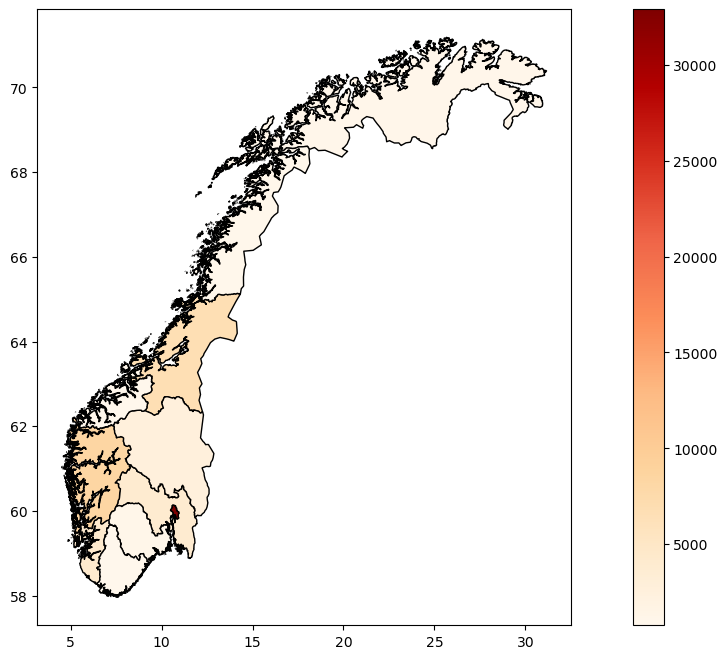

In [40]:
# Add the twitter frequency to the initial shapefile
gdf_plot = gdf_NOnuts3.merge(
    gdf_frequency_county,
    left_on = 'NUTS_NAME',
    right_on = 'NUTS_NAME'
)

# Plot the results
gdf_plot.plot(
    "twitter_frequency",
    legend = True,
    edgecolor = 'black',
    figsize = (16,8),
    cmap ='OrRd'
)
#plt.axis('off')

In [41]:
count = test.groupby('NUTS_NAME').count()

In [42]:
count

,city,created_at,latitude,longitude,label,logits0,logits1,geometry,index_right,index,NUTS_ID
NUTS_NAME,,,,,,,,,,,
Agder,770,770,770,770,770,770,770,770,770,770,770
Innlandet,2591,2591,2591,2591,2591,2591,2591,2591,2591,2591,2591
Møre og Romsdal,873,873,873,873,873,873,873,873,873,873,873
Nordland,915,915,915,915,915,915,915,915,915,915,915
Oslo,32901,32901,32901,32901,32901,32901,32901,32901,32901,32901,32901
Rogaland,4280,4280,4280,4280,4280,4280,4280,4280,4280,4280,4280
Troms og Finnmark,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122
Trøndelag,6718,6718,6718,6718,6718,6718,6718,6718,6718,6718,6718
Vestfold og Telemark,1257,1257,1257,1257,1257,1257,1257,1257,1257,1257,1257


In [43]:
total = test.groupby('NUTS_NAME').sum()

In [44]:
total

,latitude,longitude,label,logits0,logits1,index_right,index
NUTS_NAME,,,,,,,
Agder,4.491764e+04,5863.053988,638.0,-750.243479,676.571819,6160,626010
Innlandet,1.578499e+05,28845.447210,1862.0,-1587.350344,1419.221138,12955,1930295
Møre og Romsdal,5.456983e+04,6036.750824,651.0,-645.145022,554.804688,7857,1310373
Nordland,6.146210e+04,12934.200072,667.0,-586.819848,524.551819,9150,1374330
Oslo,1.971222e+06,353336.392538,25313.0,-26317.518561,25229.873118,197406,26057592
Rogaland,2.527533e+05,24855.843350,3166.0,-3014.936387,2819.640361,4280,3073040
Troms og Finnmark,7.801054e+04,23293.697582,795.0,-747.320290,648.729492,4488,808962
Trøndelag,4.264627e+05,71150.305740,5278.0,-6091.777254,5890.981559,20154,4836960
Vestfold og Telemark,7.447457e+04,12333.512884,882.0,-778.178472,683.750648,8799,1000572


In [45]:
new = total.copy()

In [46]:
new['negative_tweets'] = count['label'] - total['label']

In [47]:
new['non_negative_tweets'] = total['label']

In [48]:
new

,latitude,longitude,label,logits0,logits1,index_right,index,negative_tweets,non_negative_tweets
NUTS_NAME,,,,,,,,,
Agder,4.491764e+04,5863.053988,638.0,-750.243479,676.571819,6160,626010,132.0,638.0
Innlandet,1.578499e+05,28845.447210,1862.0,-1587.350344,1419.221138,12955,1930295,729.0,1862.0
Møre og Romsdal,5.456983e+04,6036.750824,651.0,-645.145022,554.804688,7857,1310373,222.0,651.0
Nordland,6.146210e+04,12934.200072,667.0,-586.819848,524.551819,9150,1374330,248.0,667.0
Oslo,1.971222e+06,353336.392538,25313.0,-26317.518561,25229.873118,197406,26057592,7588.0,25313.0
Rogaland,2.527533e+05,24855.843350,3166.0,-3014.936387,2819.640361,4280,3073040,1114.0,3166.0
Troms og Finnmark,7.801054e+04,23293.697582,795.0,-747.320290,648.729492,4488,808962,327.0,795.0
Trøndelag,4.264627e+05,71150.305740,5278.0,-6091.777254,5890.981559,20154,4836960,1440.0,5278.0
Vestfold og Telemark,7.447457e+04,12333.512884,882.0,-778.178472,683.750648,8799,1000572,375.0,882.0


In [49]:
new = new.drop(columns={
    'latitude',
    'longitude',
    'label',
    'logits0',
    'logits1',
    'index_right',
    'index'
}
)

Text(0.5, -50.2777777777778, 'County')

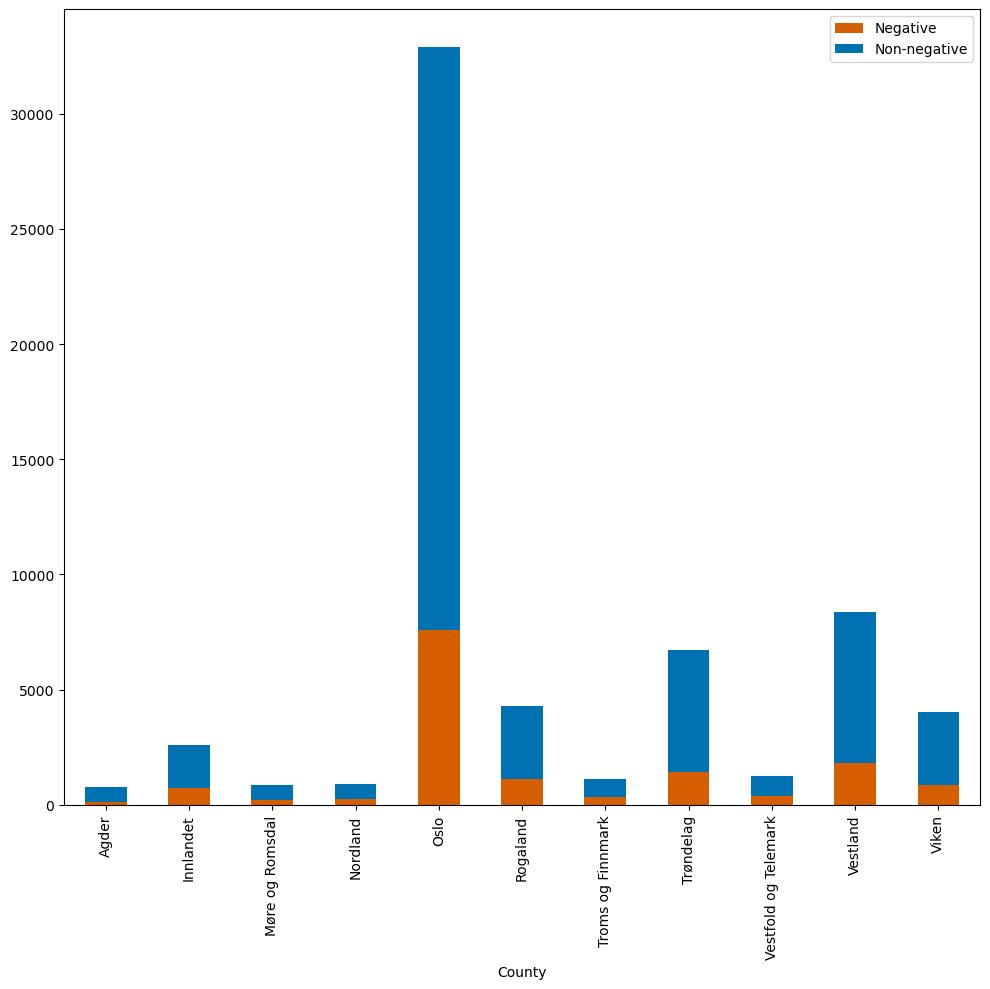

In [50]:
fig, ax = plt.subplots(figsize = (10,10))

new.rename(
    columns={
        "negative_tweets": "Negative",
        "non_negative_tweets": "Non-negative"
    }
).plot.bar(
    ax=ax,
    stacked=True,
    color = [vermilion,blue]
    #title = 'Amount of tweets per county, with sentiment score'
)

plt.tight_layout()
plt.xlabel('County')
#plt.savefig('figures/tweets_per_county_sentiment.eps')

In [51]:
new2 = new.copy()

In [52]:
new2['share_negative'] = new['negative_tweets']/(new['negative_tweets'] + new['non_negative_tweets'])
new2['share_non_negative'] = new['non_negative_tweets']/(new['negative_tweets'] + new['non_negative_tweets'])

In [53]:
new2.drop(
    columns={
        'negative_tweets',
        'non_negative_tweets'
    }
).sort_values('share_negative', ascending=False)

,share_negative,share_non_negative
NUTS_NAME,,
Vestfold og Telemark,0.298329,0.701671
Troms og Finnmark,0.291444,0.708556
Innlandet,0.281359,0.718641
Nordland,0.271038,0.728962
Rogaland,0.260280,0.739720
Møre og Romsdal,0.254296,0.745704
Oslo,0.230631,0.769369
Vestland,0.219296,0.780704
Viken,0.215759,0.784241


In [54]:
my_tuple = (1,2)

In [55]:
x = 1342.1203

In [56]:
round(1342.1203, 0)

1342.0

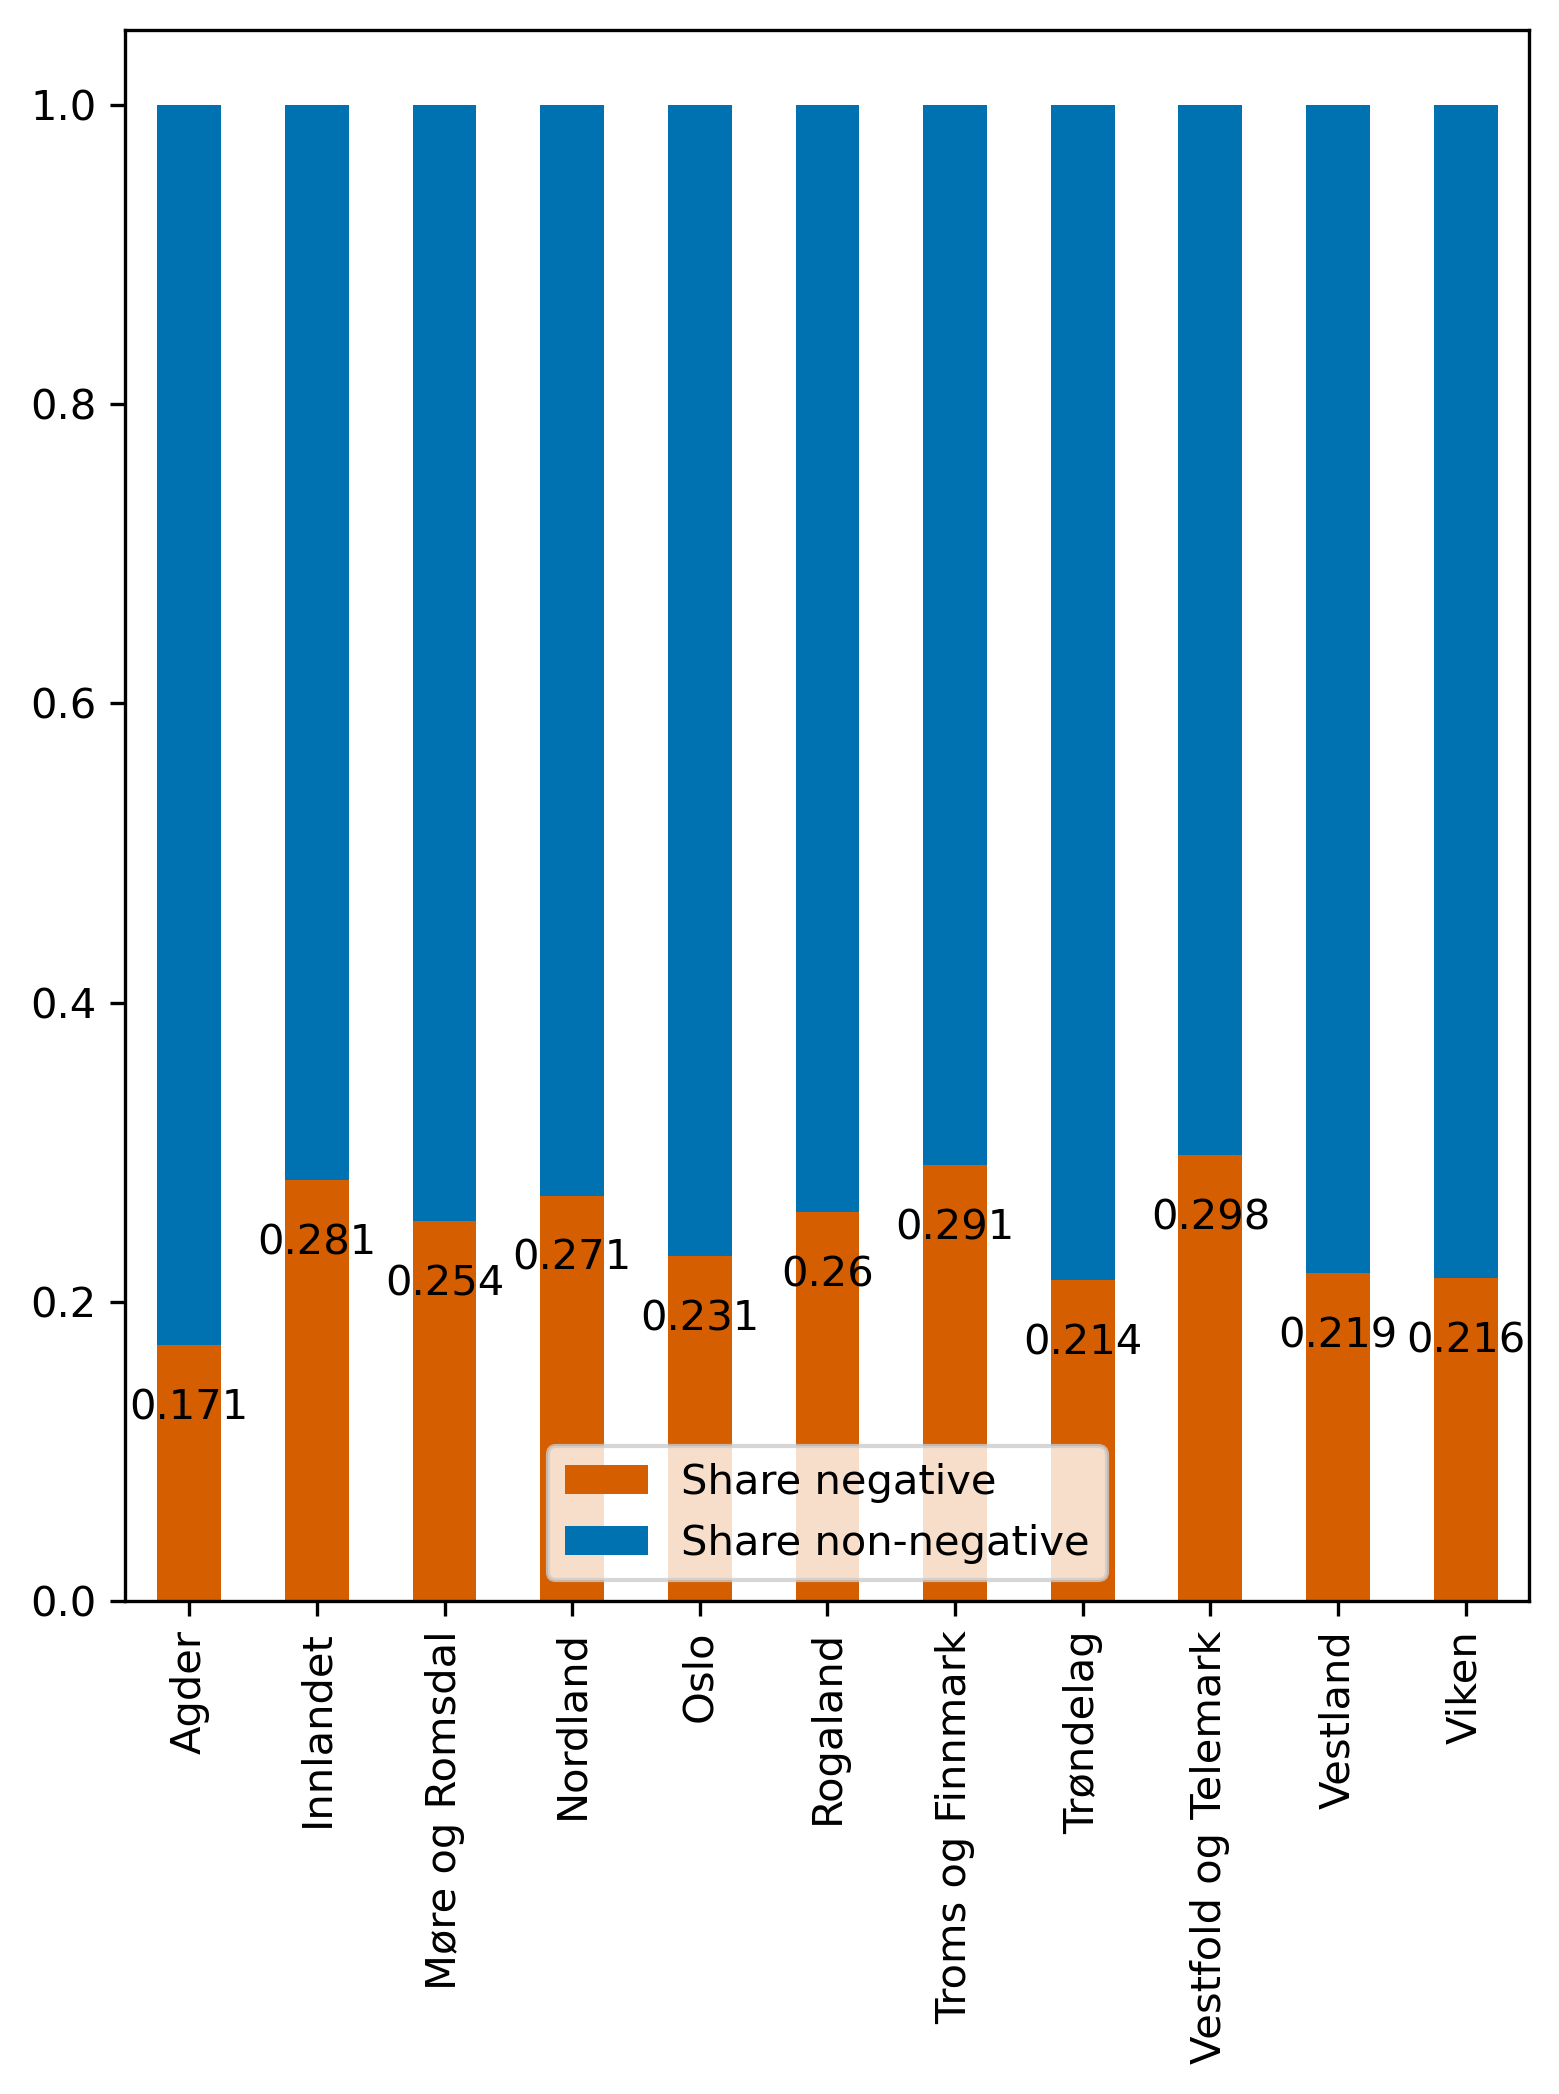

In [85]:
fig, ax=plt.subplots(figsize=(1.5*3.54,2*3.54), dpi=300)


new2.drop(
    columns={
        'negative_tweets',
        'non_negative_tweets'
    }
).rename(
    columns={
        "share_negative": "Share negative",
        "share_non_negative": "Share non-negative",
    }
).plot.bar(
    stacked=True,
    ax=ax,
    #ylim = [0,1.1],
    color = [vermilion, blue]
)

for container in ax.containers:
    labels = [round(v,3) if v < 0.5 else "" for v in container.datavalues] 
    ax.bar_label(
        container,
        labels = labels,
        padding=-20,
        #color = 'white'
    )

#ax.set_ylim(0,1.15)
ax.legend(loc= 'lower center')
    
plt.xlabel('')
plt.tight_layout()
#plt.legend(bbox_to_anchor=(1.0, 1.0))
#plt.savefig('figures/sentiment_score_county.eps',bbox_inches='tight')

### Temporal development per county and region

In [58]:
gdf_twitter_monthly_senti = gpd.GeoDataFrame(
    df_twitter,
    crs = "EPSG:4326",
    geometry=gpd.points_from_xy(df_twitter.longitude, df_twitter.latitude)
)
gdf_twitter_monthly_senti.index = gdf_twitter_monthly_senti['created_at'].dt.to_period('M')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [59]:
gdf_twitter_monthly_senti = gdf_twitter_monthly_senti.sjoin(
    gdf_NOnuts3, 
    how="inner", 
    predicate='intersects'
)

In [60]:
df_twitter_monthly_senti = pd.DataFrame(gdf_twitter_monthly_senti.drop(
    columns={
        'username',
        'like_count',
        'quote_count',
        'index',
        'LEVL_CODE',
        'CNTR_CODE',
        'NAME_LATN',
        'MOUNT_TYPE',
        'URBN_TYPE',
        'COAST_TYPE',
        'index_right',
        'text',
        'FID',
        'logits0',
        'logits1',
        'latitude',
        'longitude',
        'geometry',
        'NUTS_ID',
        'Unnamed: 0',
        'loc'
    }
))

In [61]:
df_twitter_monthly_senti.NUTS_NAME.unique()

array(['Møre og Romsdal', 'Nordland', 'Oslo', 'Vestland', 'Innlandet',
       'Rogaland', 'Trøndelag', 'Troms og Finnmark', 'Agder',
       'Vestfold og Telemark', 'Viken'], dtype=object)

In [62]:
df_twitter_monthly_senti = df_twitter_monthly_senti.drop(columns={'created_at'})

In [63]:
#df_twitter_monthly_senti['year'] = 

### 5 Regions

* Northern Norway = Troms og Finnmark + Nordland
* Trøndelag = Trøndelag
* Western Norway = Møre og Romsdal + Vestland + Rogaland
* Eastern + Southern Norway = Vestfold og Telemark + Viken + Innlandet + Oslo + Agder

Since Agder is the only county in Southern Norway, we add it to Eastern Norway

In [64]:
regions = ['Northern Norway','Western Norway', 'East- and Southern Norway', 'Trøndelag']

In [65]:
df_twitter_monthly_senti_regional = df_twitter_monthly_senti.replace(
    {
        'Troms og Finnmark' : 'Northern Norway',
        'Nordland' : 'Northern Norway',
        'Møre og Romsdal' : 'Western Norway',
        'Vestland' : 'Western Norway',
        'Rogaland' : 'Western Norway',
        'Vestfold og Telemark' : 'East- and Southern Norway',
        'Viken' : 'East- and Southern Norway',
        'Innlandet' : 'East- and Southern Norway',
        'Oslo' : 'East- and Southern Norway',
        'Agder' : 'East- and Southern Norway',
    }
)

In [66]:
df_twitter_monthly_senti_regional_grouped = df_twitter_monthly_senti_regional.groupby('NUTS_NAME').count()

In [67]:
df_twitter_monthly_senti_regional_grouped = df_twitter_monthly_senti_regional_grouped.rename(
    columns = {'label' : 'total'}
).assign(
    non_neg = lambda x : df_twitter_monthly_senti_regional.groupby('NUTS_NAME').sum(),
    neg = lambda x : x.total - x.non_neg,
    share_neg = lambda x : round(x.neg/x.total,3),
    share_non_neg = lambda x : round(x.non_neg/x.total,3)
)

In [68]:
df_twitter_monthly_senti_regional_grouped

,total,non_neg,neg,share_neg,share_non_neg
NUTS_NAME,,,,,
East- and Southern Norway,41542,31850.0,9692.0,0.233,0.767
Northern Norway,2037,1462.0,575.0,0.282,0.718
Trøndelag,6718,5278.0,1440.0,0.214,0.786
Western Norway,13507,10339.0,3168.0,0.235,0.765


In [69]:
df_twitter_monthly_senti_regional

,label,NUTS_NAME
created_at,,
2008-12,1.0,Western Norway
2008-11,1.0,Western Norway
2008-08,1.0,Western Norway
2008-05,1.0,Western Norway
2009-09,1.0,Western Norway
...,...,...
2022-10,0.0,East- and Southern Norway
2022-10,1.0,East- and Southern Norway
2022-10,1.0,East- and Southern Norway


In [70]:
#for year in df_twitter_monthly_senti_regional.groupby('

### County level

Test case with Agder

In [71]:
df_Agder = df_twitter_monthly_senti.loc[df_twitter_monthly_senti['NUTS_NAME'] == 'Agder']

In [72]:
df_Agder

,label,NUTS_NAME
created_at,,
2009-04,1.0,Agder
2009-07,1.0,Agder
2009-12,1.0,Agder
2010-05,0.0,Agder
2010-03,1.0,Agder
...,...,...
2022-10,1.0,Agder
2022-10,0.0,Agder
2022-10,1.0,Agder


In [73]:
df_wp_Trondelag = pd.read_csv(
    'data/norway_wp_nve_250522.tsv', sep = "\t",
    parse_dates = ['Produksjon oppstart']
)

df_wp_Trondelag = df_wp_Trondelag.loc[df_wp_Trondelag['Fylke'] == 'Trøndelag'].groupby(
    'Produksjon oppstart',
    as_index = False
).sum()

#df_wp_Agder['year'] = df_wp_Agder['Produksjon oppstart'].to_numpy().astype('datetime64[Y]')
#time_adjust = pd.Timedelta(pd.to_datetime('10.06.2020', format='%d.%m.%Y') -pd.to_datetime('01.01.2020', format = '%d.%m.%Y'))
#df_wp_Agder['year'] += time_adjust
#df_wp_Agder

In [74]:
df_wp_Trondelag

,Produksjon oppstart,Installert effekt [MW],Middelproduksjon [GWh],Antall turbiner,Prisområde
0,1998-01-01,55.000,211.065,14.0,3.0
1,2004-01-01,55.200,138.000,24.0,3.0
2,2006-01-01,11.500,35.000,5.0,3.0
3,2007-01-01,57.500,175.000,25.0,3.0
4,2012-01-01,39.100,103.000,17.0,3.0
5,2015-01-01,13.425,36.300,5.0,6.0
6,2018-01-01,255.600,900.000,71.0,3.0
7,2019-01-01,394.200,1307.700,109.0,9.0
8,2020-01-01,478.800,1622.390,114.0,12.0
9,2021-01-01,218.400,796.680,52.0,6.0


<AxesSubplot:xlabel='Produksjon oppstart'>

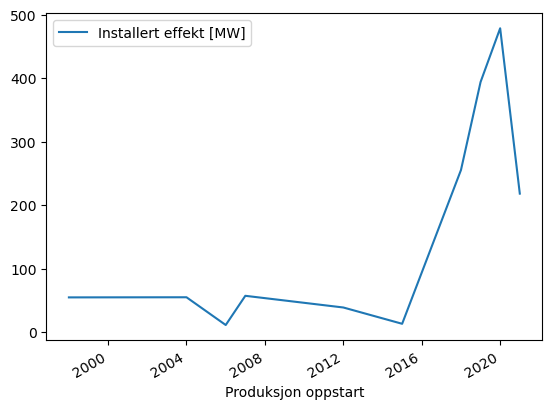

In [75]:
df_wp_Trondelag.set_index('Produksjon oppstart').plot(
    y = 'Installert effekt [MW]'
)

In [76]:
#pd.read_csv(
#    'data/norway_wp_nve_250522.tsv', sep = "\t",
#    parse_dates = ['Produksjon oppstart']
#).loc[df_wp_Agder['Fylke'] == 'Agder'].groupby(
#    'Produksjon oppstart',
#    as_index = False
#).sum(
#).rename(
#    columns=
#    {
#        'Middelproduksjon [GWh]': 'average_generation_GWh',
#        'Installert effekt [MW]': 'installed_capacity_MW'
#    }
#).assign(
#    cumulative_annually_average_production_GWh = lambda x: x.average_generation_GWh.cumsum(),
#    cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
#)

df_wp_Agder['year'] = df_wp_Agder['Produksjon oppstart'].to_numpy().astype('datetime64[Y]')
time_adjust = pd.Timedelta(pd.to_datetime('10.06.2020', format='%d.%m.%Y') -pd.to_datetime('01.01.2020', format = '%d.%m.%Y'))
df_wp_Agder['year'] += time_adjust
df_wp_Agder


NameError: name 'df_wp_Agder' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))

ax2 = ax.twinx()
df_wp_Agder.assign(
    non_negative_tweets=lambda x: x.groupby(level=0).sum()
).assign(
    amount=lambda x: x.groupby(level=0).count().label
).assign(
    negative_tweets=lambda x: x.amount - x.non_negative_tweets
).drop(columns={
    'amount',
    'label'
}
  ).sort_values('created_at').plot(
    ax=ax,
    title = 'Amount of tweets over time (aggregated monthly), with binary classification',
    color = [vermilion,blue]
)

ax.axvline(
    dt.datetime(2019, 4, 1),
    color="#E69F00",
    label='NVE present proposed National Framework for Wind Power',
    linestyle = "--"
)

ax.axvline(
    dt.datetime(2019, 9, 1),
    color="#000000",
    label='Municipal and regional election',
    linestyle = "--"
)

ax.axvline(
    dt.datetime(2020, 6, 1),
    color="#CC79A7",
    label='Meld. St. 28 (2019-2020) - Tighter rules for wind power introduced',
    linestyle = "--"
)

ax.axvline(
    dt.datetime(2021, 9, 1),
    color="#56B4E9",
    label='Parliamentary election and Fosen Wind controversy',
    linestyle = "--"
)

df_wp_Agder = pd.read_csv(
    'data/norway_wp_nve_250522.tsv', sep = "\t",
    parse_dates = ['Produksjon oppstart']
)

df_wp_Agder = df_wp_Agder.loc[df_wp_Agder['Fylke'] == 'Agder'].groupby(
    'Produksjon oppstart',
    as_index = False
).sum(
).rename(
    columns=
    {
        'Middelproduksjon [GWh]': 'average_generation_GWh',
        'Installert effekt [MW]': 'installed_capacity_MW'
    }
).assign(
    cumulative_annually_average_production_GWh = lambda x: x.average_generation_GWh.cumsum(),
    cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
)

df_wp_Agder['year'] = df_wp_Agder['Produksjon oppstart'].to_numpy().astype('datetime64[Y]')
time_adjust = pd.Timedelta(pd.to_datetime('10.06.2020', format='%d.%m.%Y') -pd.to_datetime('01.01.2020', format = '%d.%m.%Y'))
df_wp_Agder['year'] += time_adjust
df_wp_Agder.plot(
        ax=ax2,
        y = ['cumulative_installed_capacity_MW'], #, 'average_generation_GWh'],
        x = 'year'
)

ax.set_xlim([dt.date(2008, 1, 1), dt.date(2022, 12, 12)])
ax2.grid(None)
ax2.set_ylabel('installed windpower capacity [MW]')


ax.legend(fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Number of tweets')
#plt.savefig('figures/agder_test.png')

In [ ]:
counties = ['Agder',
            'Innlandet',
            'Møre og Romsdal',
            'Nordland',
            'Oslo',
            'Rogaland',
           'Troms og Finnmark',
            'Trøndelag',
            'Vestfold og Telemark',
            'Vestland',
            'Viken'
           ]

In [ ]:
row_nr = 0
column_nr = 0
fig = plt.figure(
    constrained_layout=False,
    figsize=(30,15)
)
gs = fig.add_gridspec(4,3, wspace=0.4, hspace = 1)

for county in counties:
    df_twitter_monthly_senti.loc[df_twitter_monthly_senti['NUTS_NAME'] == county].assign(
        non_negative_tweets=lambda x: x.groupby(level=0).sum()
    ).assign(
        amount=lambda x: x.groupby(level=0).count().label
    ).assign(
        negative_tweets=lambda x: x.amount - x.non_negative_tweets
    ).drop(columns={
        'amount',
        'label'
    }
      ).rename(
    columns={
        "negative_tweets": "Negative",
        "non_negative_tweets": "Non-negative"
    }
    ).sort_values(
        'created_at'
    ).plot(
        ax=fig.add_subplot(gs[row_nr,column_nr]),
        title = county,
        color = [blue,vermilion]
    )
    column_nr += 1
    if column_nr == 3:
        column_nr = 0
        row_nr += 1
    plt.xlabel('Year')
    plt.ylabel('Amount of tweets')
    ax.axvline(
    dt.datetime(2019, 4, 1),
    color="#E69F00",
    label='NVE present proposed National Framework for Wind Power',
    linestyle = "--"
)

#plt.savefig('figures/temporal_all_counties.eps')

In [ ]:
for county in counties:
    df_twitter_monthly_senti.loc[df_twitter_monthly_senti['NUTS_NAME'] == county].assign(
        non_negative_tweets=lambda x: x.groupby(level=0).sum()
    ).assign(
        amount=lambda x: x.groupby(level=0).count().label
    ).assign(
        negative_tweets=lambda x: x.amount - x.non_negative_tweets
    ).drop(columns={
        'amount',
        'label'
    }
      ).rename(
        columns={
            "negative_tweets": "Negative",
            "non_negative_tweets": "Non-negative"
        }
    ).sort_values(
        'created_at'
    ).plot(
        title = county,
        color = [blue,vermilion] 
    )
    #plt.tight_layout()
    plt.xlabel('Year')
    plt.ylabel('Number of tweets')
    #plt.savefig('figures/temporal_new_'+str(county.replace(" ", ""))+'.eps')
    #plt.close()
    

In [ ]:
df_twitter_yearly

In [ ]:
for county in counties:
    df_twitter_yearly.loc[df_twitter_yearly['NUTS_NAME'] == county].assign(
        non_negative_tweets=lambda x: x.groupby(level=0).sum()
    ).assign(
        amount=lambda x: x.groupby(level=0).count().label
    ).assign(
        negative_tweets=lambda x: x.amount - x.non_negative_tweets
    ).assign(
        share_negative = lambda x: x.negative_tweets/x.amount
    ).drop(columns={
        'amount',
        'label',
        'non_negative_tweets',
        'negative_tweets'
    }
    ).sort_values(
        'created_at'
    ).plot.bar(
        title = county,
        color = [blue,vermilion] 
    )
    #plt.tight_layout()
    plt.xlabel('Year')
    plt.ylabel('Number of tweets')
    #plt.savefig('figures/temporal_new_'+str(county.replace(" ", ""))+'.eps')
    #plt.close()
    

## Aggregated to zones

## Wild testing

In [86]:
df_twitter_yearly = pd.DataFrame(df_twitter.copy())
df_twitter_yearly.index = df_twitter_yearly['created_at'].dt.to_period('Y')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [87]:
years = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']

In [88]:
a_list = []
for year in years:
    x = [year, df_twitter_yearly.loc[year].label.mean()]
    a_list.append(x)

In [89]:
df_year_averages = pd.DataFrame(a_list, columns=['year','share_non_negative'])

In [99]:
a_list

[['2008', 0.875],
 ['2009', 0.9172749391727494],
 ['2010', 0.8944281524926686],
 ['2011', 0.8915145005370569],
 ['2012', 0.8571428571428571],
 ['2013', 0.8434554973821989],
 ['2014', 0.8830436824800376],
 ['2015', 0.893872647176612],
 ['2016', 0.86015625],
 ['2017', 0.8280881195908734],
 ['2018', 0.7393066186402522],
 ['2019', 0.739910029778876],
 ['2020', 0.6754966887417219],
 ['2021', 0.7468460891505467],
 ['2022', 0.7896797510290131]]

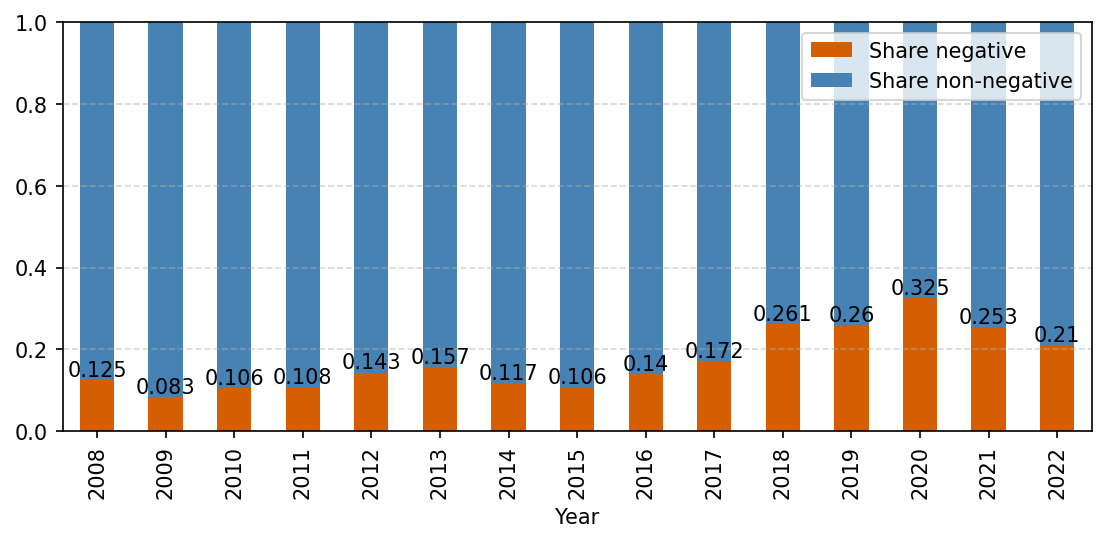

In [97]:
fig, ax=plt.subplots(figsize=(3.54*2.5,3.54),dpi=150)

df_year_averages.assign(
    share_negative=lambda x: 1-x.share_non_negative
).set_index(
    'year'
).plot.bar(
    ax=ax,
    y = ['share_negative','share_non_negative'],
    stacked=True,
    color = [vermilion,'steelblue']
)
#plt.legend(bbox_to_anchor=(1.0, 1.0))

for container in ax.containers:
    labels = [round(v,3) if v < 0.4 else "" for v in container.datavalues] 
    ax.bar_label(
        container,
        labels = labels,
        padding= 0,
        color = 'black',
    )

plt.legend(['Share negative','Share non-negative'],facecolor='white',framealpha=None,loc='upper right')
plt.grid(linestyle = '--', alpha = 0.5, axis = 'y')
plt.ylim([0,1])
plt.xlabel('Year')
plt.savefig('figures/share_negative_time.pdf',bbox_inches='tight')

In [ ]:
df_year_averages

In [ ]:
df_year_averages.assign(
    share_negative=lambda x: 1-x.share_non_negative
).set_index(
    'year'
).plot.bar(
    stacked=True,
    color = [blue,vermilion]
)

In [ ]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(12,6)
)
gs = fig.add_gridspec(1,1, wspace=0.4, hspace = 1)

df_twitter_monthly_senti.loc[df_twitter_monthly_senti['NUTS_NAME'] == county].assign(
        non_negative_tweets=lambda x: x.groupby(level=0).sum()
    ).assign(
        amount=lambda x: x.groupby(level=0).count().label
    ).assign(
        negative_tweets=lambda x: x.amount - x.non_negative_tweets
    ).drop(columns={
        'amount',
        'label'
    }
      ).rename(
        columns={
            "negative_tweets": "Negative",
            "non_negative_tweets": "Non-negative"
        }
    ).plot(
        ax=fig.add_subplot(gs[0,0]),
        title = county,
        color = [blue,vermilion] 
    )
    

plt.xlabel('Year')
plt.ylabel('Number of tweets')

In [ ]:
gdf_twitter_yearly_senti

In [ ]:
#gdf_spatio_temporal = 
gdf_twitter_yearly_senti.groupby(
    ['NUTS_NAME','year']
).count(
).assign(
        non_negative_tweets = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").sum().label,
        amount = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").count().label,
        negative_tweets = lambda x: x.amount - x.non_negative_tweets,
        share_negative = lambda x: x.negative_tweets/x.amount
    )

In [ ]:
gdf_spatio_temporal

In [ ]:
for year in gdf_twitter_yearly_senti.groupby('year').sum().index:
    gdf_twitter_yearly_grouped = gdf_twitter_yearly_senti.loc[
        gdf_twitter_yearly_senti['year'] == year
    ].groupby("NUTS_NAME").first(
    ).assign(
        non_negative_tweets = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").sum().label,
        amount = lambda x: gdf_twitter_yearly_senti.loc[gdf_twitter_yearly_senti['year'] == year].groupby("NUTS_NAME").count().label,
        negative_tweets = lambda x: x.amount - x.non_negative_tweets,
        share_negative = lambda x: x.negative_tweets/x.amount
    )